In [1]:
import os, gc, torch, PIL, pickle

import pandas as pd
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from data.constants import XAMI_MIMIC_PATH
from models.load import get_model_label, get_model_name, get_current_epoch, get_dataset_label
# from models.load import TrainedModels
## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
from enum import Enum

class TrainedModels(Enum):
    
    pretrained_resnet50_without_clinical_ap = "val_ar_0_5272_ap_0_2396_test_ar_0_6170_ap_0_1962_epoch44_WithoutClincal_04-19-2022 07-35-55_pretrained_resnet50_without_clinical"
    pretrained_resnet50_without_clinical_ar = "val_ar_0_5272_ap_0_2396_test_ar_0_6170_ap_0_1962_epoch44_WithoutClincal_04-19-2022 07-35-46_pretrained_resnet50_without_clinical"
    pretrained_resnet50_without_clinical_final = "val_ar_0_3257_ap_0_1868_test_ar_0_4210_ap_0_1598_epoch100_WithoutClincal_04-19-2022 12-44-29_pretrained_resnet50_without_clinical"

    pretrained_resnet50_with_clinical_ap = "val_ar_0_4246_ap_0_2378_test_ar_0_4963_ap_0_1712_epoch98_WithClincal_04-19-2022 22-54-16_pretrained_resnet50_with_clinical"
    pretrained_resnet50_with_clinical_ar = "val_ar_0_5164_ap_0_1869_test_ar_0_5086_ap_0_1718_epoch64_WithClincal_04-19-2022 19-33-35_pretrained_resnet50_with_clinical"
    pretrained_resnet50_with_clinical_final = "val_ar_0_3271_ap_0_1848_test_ar_0_3900_ap_0_1726_epoch100_WithClincal_04-19-2022 23-06-47_pretrained_resnet50_with_clinical"

    custom_with_clinical_no_pretrained_ar = "val_ar_0_5220_ap_0_2513_test_ar_0_5590_ap_0_2442_epoch150_WithClincal_04-13-2022 20-13-47_custom_with_clinical_no_pretrained"
    custom_with_clinical_no_pretrained_ap = "val_ar_0_4554_ap_0_2582_test_ar_0_5254_ap_0_2405_epoch139_WithClincal_04-13-2022 19-05-08_custom_with_clinical_no_pretrained"
    custom_with_clinical_no_pretrained_final = "val_ar_0_4523_ap_0_2251_test_ar_0_5103_ap_0_2464_epoch200_WithClincal_04-14-2022 01-32-28_custom_with_clinical_no_pretrained"

    custom_without_clinical_no_pretrained_ar = "val_ar_0_5645_ap_0_2659_test_ar_0_6263_ap_0_2533_epoch145_WithoutClincal_04-13-2022 08-47-34_custom_without_clinical_no_pretrained"
    custom_without_clinical_no_pretrained_ap = "val_ar_0_5512_ap_0_2962_test_ar_0_5999_ap_0_2319_epoch93_WithoutClincal_04-12-2022 09-15-28_custom_without_clinical_no_pretrained"
    custom_without_clinical_no_pretrained_final = "val_ar_0_3757_ap_0_1699_test_ar_0_4421_ap_0_1819_epoch200_WithoutClincal_04-13-2022 14-58-52_custom_without_clinical_no_pretrained"

    custom_without_clinical_swim_ap = "val_ar_0_5307_ap_0_2054_test_ar_0_5321_ap_0_1726_epoch87_WithoutClincal_04-17-2022 06-51-10_custom_without_clinical_swim"
    custom_without_clinical_swim_ar = "val_ar_0_5313_ap_0_1540_test_ar_0_5906_ap_0_1486_epoch59_WithoutClincal_04-17-2022 05-48-30_custom_without_clinical_swim"
    custom_without_clinical_swim_final = "val_ar_0_2175_ap_0_1390_test_ar_0_2231_ap_0_0901_epoch200_WithoutClincal_04-17-2022 10-49-59_custom_without_clinical_swim"

    custom_with_clinical_swim_ap = "val_ar_0_5081_ap_0_2210_test_ar_0_5392_ap_0_1725_epoch95_WithClincal_04-17-2022 15-26-02_custom_with_clinical_swim"
    custom_with_clinical_swim_ar = "val_ar_0_5377_ap_0_1821_test_ar_0_4561_ap_0_1193_epoch67_WithClincal_04-17-2022 14-02-28_custom_with_clinical_swim"
    custom_with_clinical_swim_final = "val_ar_0_2752_ap_0_1293_test_ar_0_3391_ap_0_1097_epoch200_WithClincal_04-17-2022 20-31-24_custom_with_clinical_swim"

    pretrained_resnet50_without_clinical_full_reflacx_ap = "val_ar_0_5746_ap_0_2865_test_ar_0_5566_ap_0_2600_epoch47_WithoutClincal_04-23-2022 07-36-59_pretrained_resnet50_without_clinical_full_reflacx"
    pretrained_resnet50_without_clinical_full_reflacx_ar = "val_ar_0_6674_ap_0_2757_test_ar_0_6313_ap_0_2751_epoch17_WithoutClincal_04-22-2022 15-59-30_pretrained_resnet50_without_clinical_full_reflacx"
    pretrained_resnet50_without_clinical_full_reflacx_final = "val_ar_0_5222_ap_0_2521_test_ar_0_4617_ap_0_2328_epoch72_WithoutClincal_04-23-2022 21-13-24_pretrained_resnet50_without_clinical_full_reflacx"


In [3]:
def get_thrs_evaluation_df(models: List[TrainedModels] , suffix, disease="all", thrs = 0.5,):
    all_models_eval_data = {}
    for select_model in models:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{suffix}_{disease}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[select_model.value] = eval_data

    return  pd.DataFrame(
            [
                {
                    "model": str(select_model).split(".")[-1],
                    **all_models_eval_data[select_model.value][thrs][0],
                } for select_model in models
            ]
        )[['model','ap', 'ar']]

In [4]:
# from models.load import TrainedModels
from typing import List

def plot_iou_result(models: List[TrainedModels] , suffix, disease="all", figsize=(10, 10)):

    cm = plt.get_cmap('rainbow')
    NUM_COLORS = len(models)

    all_models_eval_data = {}
    for select_model in models:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{suffix}_{disease}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[select_model.value] = eval_data


    fig, (precision_ax, recall_ax) = plt.subplots(
        2, figsize=figsize, dpi=80, sharex=True,
    )

    fig.suptitle(f"{suffix}")

    precision_ax.set_title("Average Precision")
    precision_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    for select_model in models:
        precision_ax.plot(
            all_models_eval_data[select_model.value].keys(),
            [v[0]["ap"] for v in all_models_eval_data[select_model.value].values()],
            marker="o",
            label=get_model_label(select_model),
            # color="darkorange",
        )
    precision_ax.legend(loc="upper right")

    recall_ax.set_title("Average Recall")
    recall_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    for select_model in models:
        recall_ax.plot(
            all_models_eval_data[select_model.value].keys(),
            [v[0]["ar"] for v in all_models_eval_data[select_model.value].values()],
            marker="o",
            label=get_model_label(select_model),
            # color="darkorange",
        )

    recall_ax.legend(loc="upper right")
    recall_ax.set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig

In [5]:
def showModelOnDatasets(select_model, datasets, disease="all", figsize=(10, 10)):
    '''
    This function used for detecting the overfitting dataset.    
    '''
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = len(datasets)

    all_models_eval_data = {}
    for dataset in datasets:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{dataset}_{disease}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[dataset] = eval_data


    fig, (precision_ax, recall_ax) = plt.subplots(
        2, figsize=figsize, dpi=80, sharex=True,
    )

    fig.suptitle(get_model_label(select_model))

    precision_ax.set_title("Average Precision")
    precision_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    for dataset in datasets:
        precision_ax.plot(
            all_models_eval_data[dataset].keys(),
            [v[0]["ap"] for v in all_models_eval_data[dataset].values()],
            marker="o",
            label=dataset,
            # color="darkorange",
        )
    precision_ax.legend(loc="upper right")

    recall_ax.set_title("Average Recall")
    recall_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    for dataset in datasets:
        recall_ax.plot(
            all_models_eval_data[dataset].keys(),
            [v[0]["ar"] for v in all_models_eval_data[dataset].values()],
            marker="o",
            label=dataset,
            # color="darkorange",
        )

    recall_ax.legend(loc="upper right")
    recall_ax.set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig


## Show the all the reuslts in single figure, then we will analysis different variables in laters sectinos.

In [6]:
TrainedModels.custom_with_clinical_no_pretrained_ar

<TrainedModels.custom_with_clinical_no_pretrained_ar: 'val_ar_0_5220_ap_0_2513_test_ar_0_5590_ap_0_2442_epoch150_WithClincal_04-13-2022 20-13-47_custom_with_clinical_no_pretrained'>

In [7]:
df = get_thrs_evaluation_df(TrainedModels, "train", thrs=0.5)
df.sort_values("ap", ascending=False)

### highest AP: custom_without_clinical_pretrained_final (0.347963)

## After some researching: SwinTransformer is not ideal in this case, since it tend to perfrom better in a larger dataset.
## Pretrained model perform better.

model        ap        ar
14           custom_without_clinical_swim_final  0.516514  0.661937
17              custom_with_clinical_swim_final  0.445881  0.609073
5       pretrained_resnet50_with_clinical_final  0.442094  0.664571
2    pretrained_resnet50_without_clinical_final  0.421114  0.629130
8      custom_with_clinical_no_pretrained_final  0.372212  0.599877
3          pretrained_resnet50_with_clinical_ap  0.368740  0.612957
11  custom_without_clinical_no_pretrained_final  0.355029  0.595222
0       pretrained_resnet50_without_clinical_ap  0.344885  0.612917
6         custom_with_clinical_no_pretrained_ar  0.341692  0.614816
1       pretrained_resnet50_without_clinical_ar  0.312215  0.558445
12              custom_without_clinical_swim_ap  0.300661  0.575057
4          pretrained_resnet50_with_clinical_ar  0.298687  0.577686
9      custom_without_clinical_no_pretrained_ar  0.291163  0.562004
7         custom_with_clinical_no_pretrained_ap  0.250758  0.495427
10     custom_without_clinical_no_pretrained_ap  0.177615  0.455372
15                 custom_with_clinical_swim_ap  0.172881  0.468275
13              custom_without_clinical_swim_ar  0.135850  0.488345
16                 custom_with_clinical_swim_ar  0.120591  0.402982

In [8]:
df = get_thrs_evaluation_df(TrainedModels, "val", thrs=0.5)
df.sort_values("ap", ascending=False)

### highest AP: custom_with_clinical_pretrained_ap (0.248162)

model        ap        ar
10     custom_without_clinical_no_pretrained_ap  0.296153  0.551214
9      custom_without_clinical_no_pretrained_ar  0.265941  0.564483
7         custom_with_clinical_no_pretrained_ap  0.258157  0.455392
6         custom_with_clinical_no_pretrained_ar  0.251415  0.522021
1       pretrained_resnet50_without_clinical_ar  0.239561  0.527216
0       pretrained_resnet50_without_clinical_ap  0.239561  0.527216
3          pretrained_resnet50_with_clinical_ap  0.237801  0.424619
8      custom_with_clinical_no_pretrained_final  0.225090  0.452287
15                 custom_with_clinical_swim_ap  0.221030  0.508131
12              custom_without_clinical_swim_ap  0.205445  0.530717
4          pretrained_resnet50_with_clinical_ar  0.186882  0.516431
2    pretrained_resnet50_without_clinical_final  0.186797  0.325692
5       pretrained_resnet50_with_clinical_final  0.184821  0.327103
16                 custom_with_clinical_swim_ar  0.182094  0.537719
11  custom_without_clinical_no_pretrained_final  0.170711  0.375663
13              custom_without_clinical_swim_ar  0.154017  0.531338
14           custom_without_clinical_swim_final  0.138985  0.217504
17              custom_with_clinical_swim_final  0.129293  0.275155

In [9]:
df = get_thrs_evaluation_df(TrainedModels, "test", thrs=0.5)
df.sort_values("ap", ascending=False)

### highest AP: custom_without_clinical_no_pretrained_ar (0.205445)

model        ap        ar
9      custom_without_clinical_no_pretrained_ar  0.253684  0.626337
8      custom_with_clinical_no_pretrained_final  0.249815  0.510277
6         custom_with_clinical_no_pretrained_ar  0.243894  0.558984
7         custom_with_clinical_no_pretrained_ap  0.240197  0.525445
10     custom_without_clinical_no_pretrained_ap  0.231927  0.599901
1       pretrained_resnet50_without_clinical_ar  0.195978  0.617031
0       pretrained_resnet50_without_clinical_ap  0.195978  0.617031
11  custom_without_clinical_no_pretrained_final  0.181944  0.442071
15                 custom_with_clinical_swim_ap  0.172691  0.539238
12              custom_without_clinical_swim_ap  0.172553  0.532054
5       pretrained_resnet50_with_clinical_final  0.171881  0.390028
4          pretrained_resnet50_with_clinical_ar  0.171830  0.508583
3          pretrained_resnet50_with_clinical_ap  0.170668  0.496329
2    pretrained_resnet50_without_clinical_final  0.159802  0.421032
13              custom_without_clinical_swim_ar  0.148607  0.590623
16                 custom_with_clinical_swim_ar  0.118907  0.456077
17              custom_with_clinical_swim_final  0.109683  0.339142
14           custom_without_clinical_swim_final  0.090082  0.223134

### Plotting the curve will be easier for comparing the models.

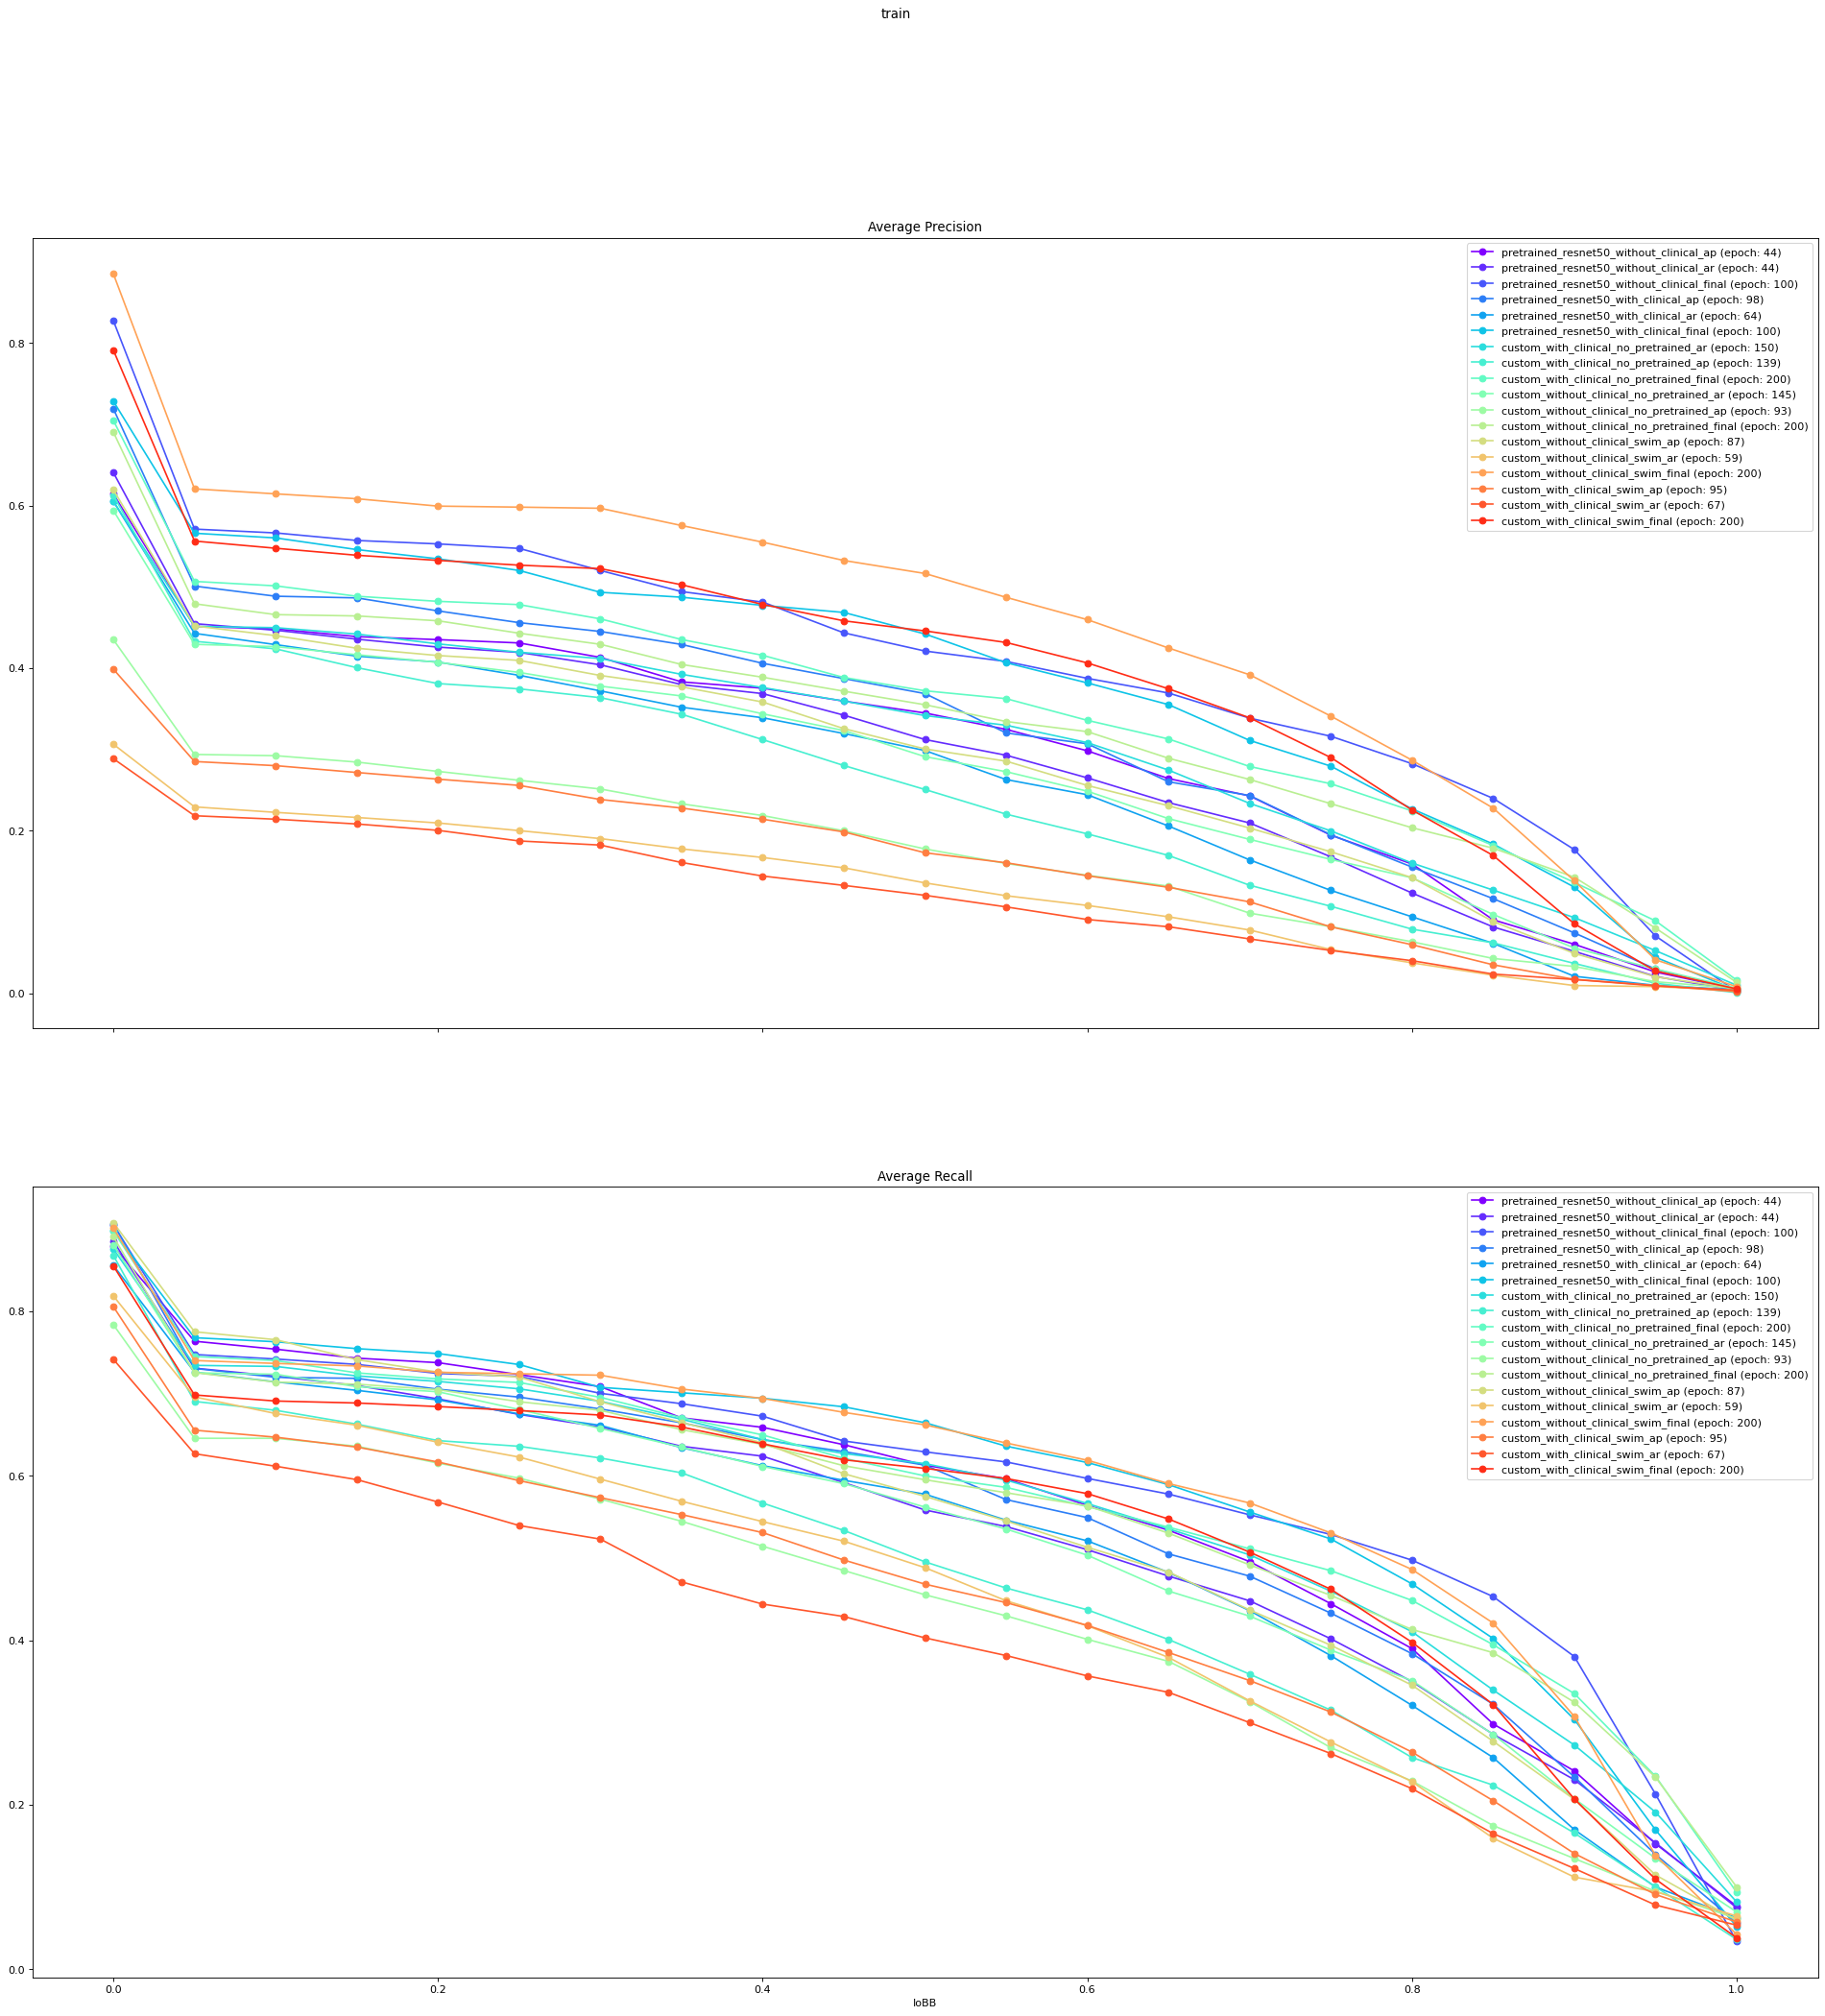

In [10]:
_ = plot_iou_result(TrainedModels, "train", figsize=(30, 30))

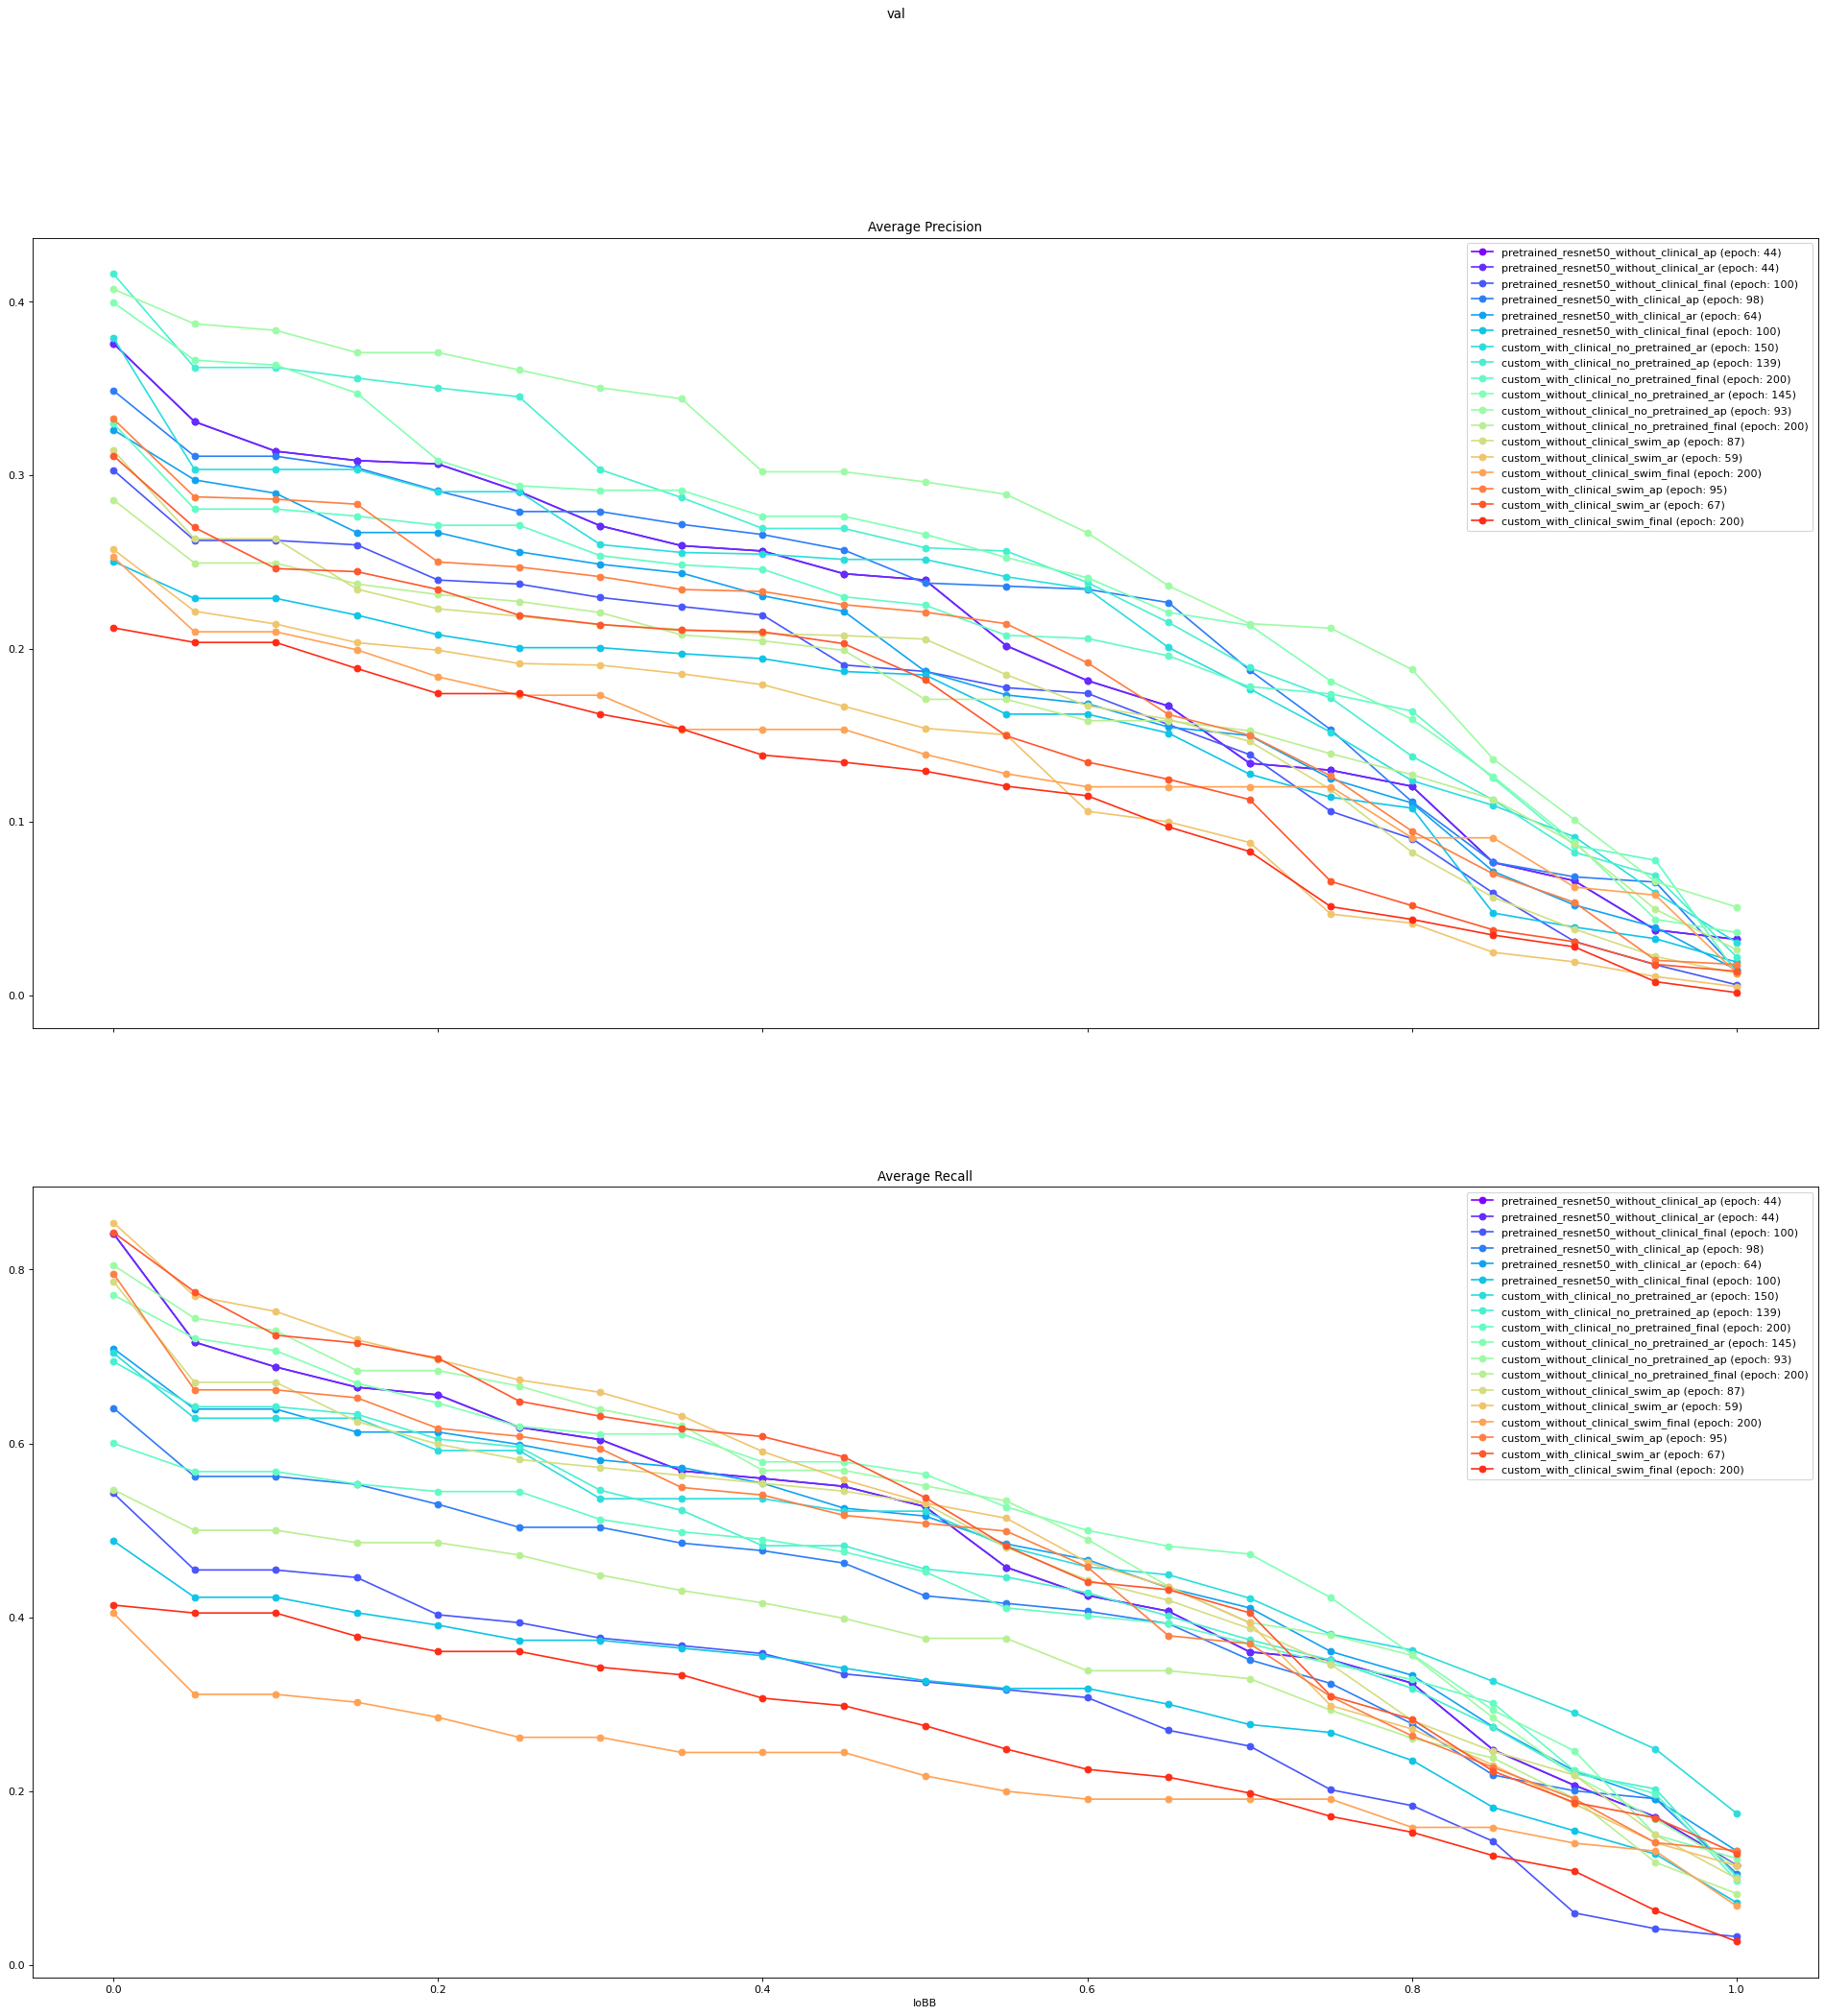

In [11]:
_ = plot_iou_result(TrainedModels, "val", figsize=(30, 30))

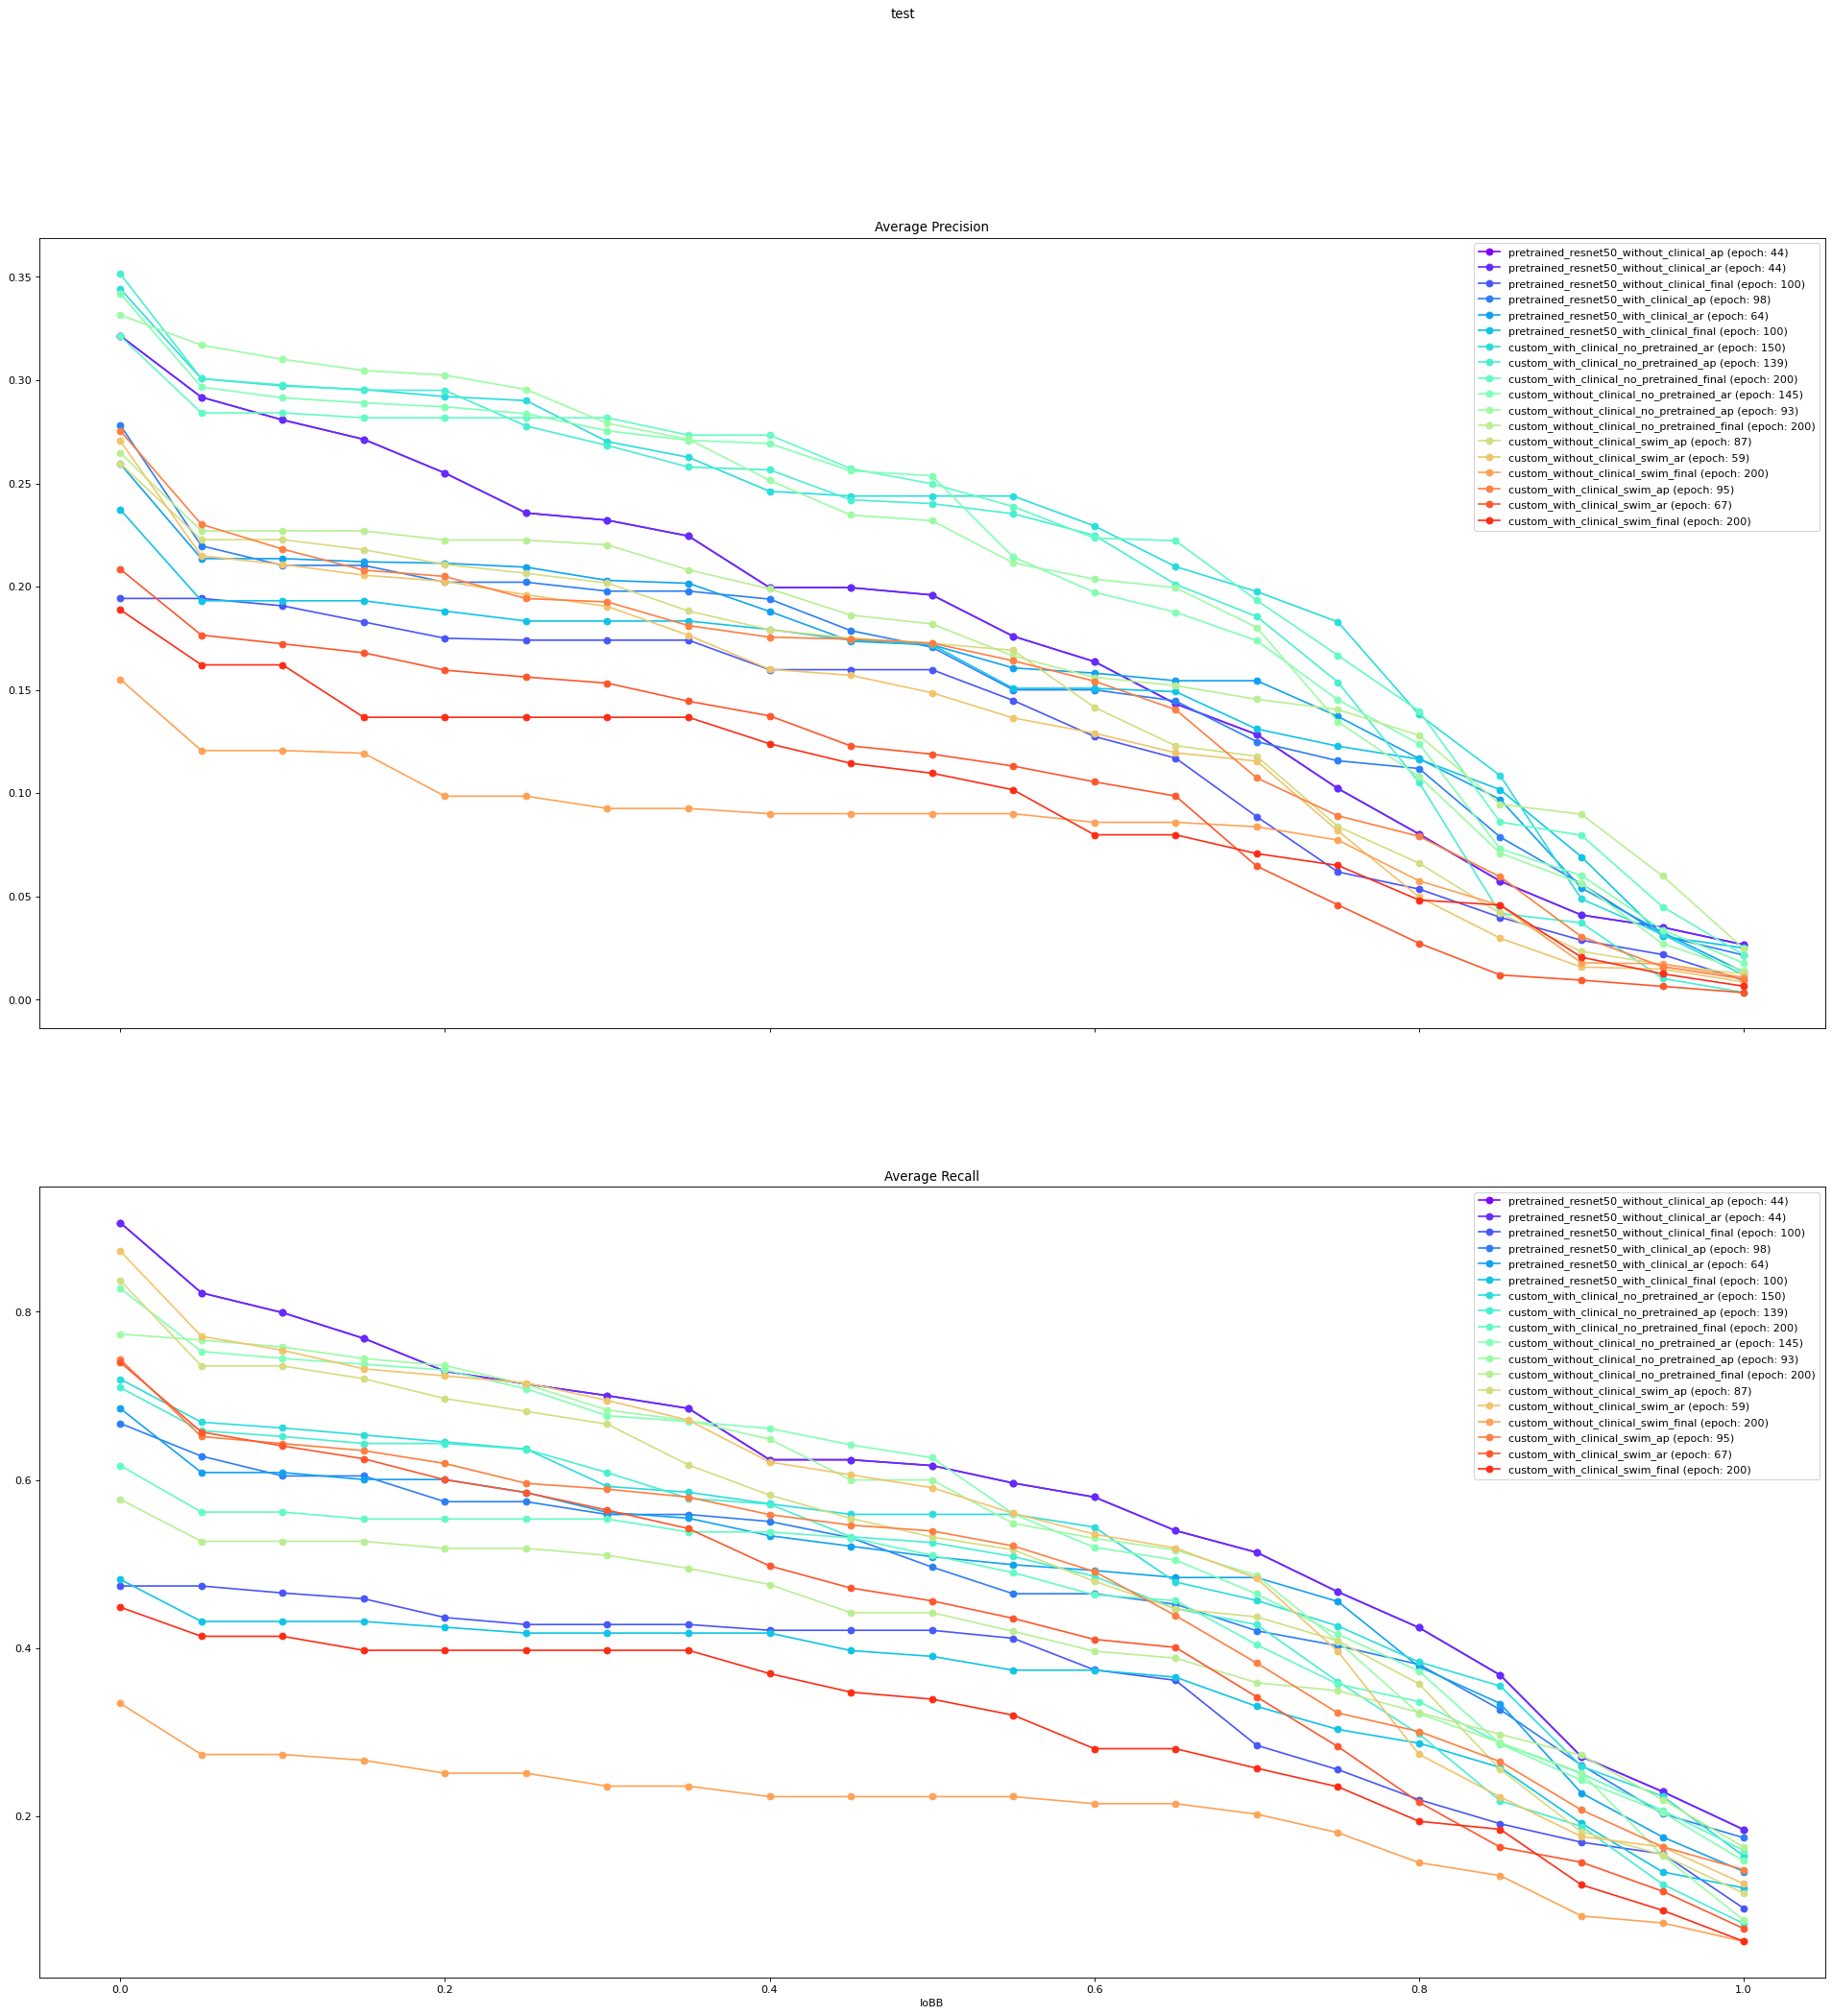

In [12]:
_ = plot_iou_result(TrainedModels, "test", figsize=(30, 30))

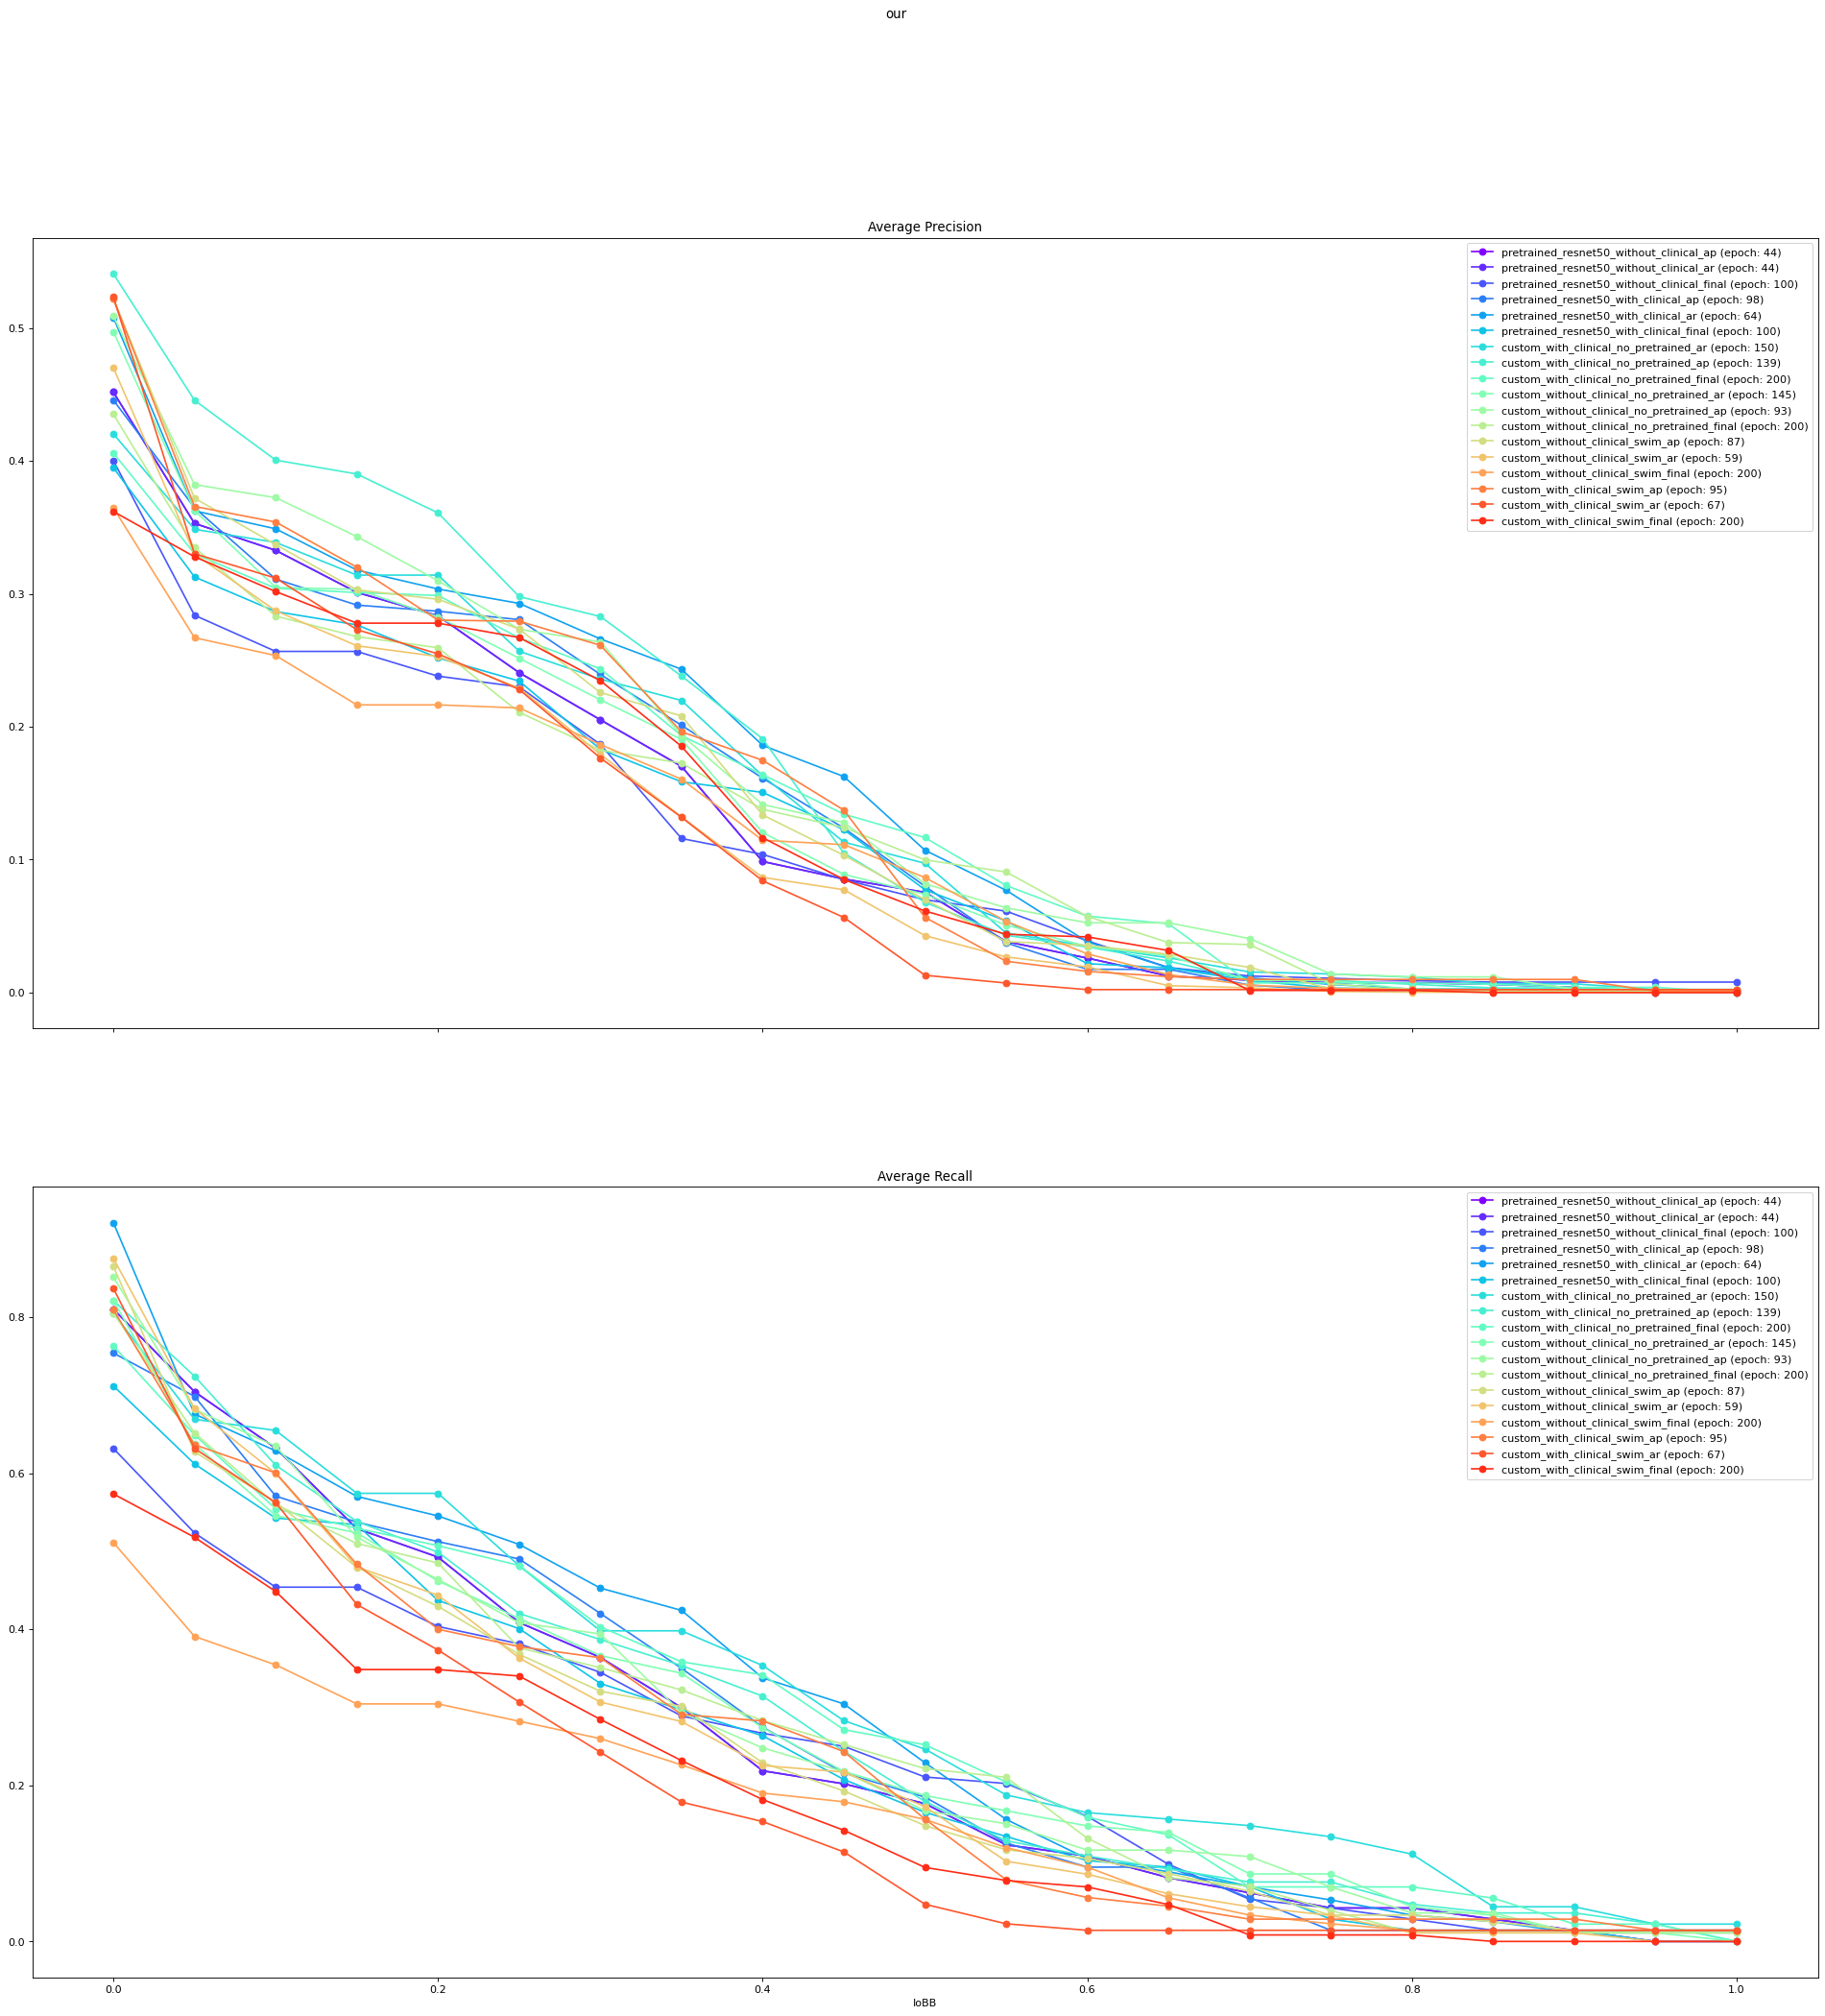

In [13]:
_ = plot_iou_result(TrainedModels, "our", figsize=(30, 30))

# See the overfitting on each model.

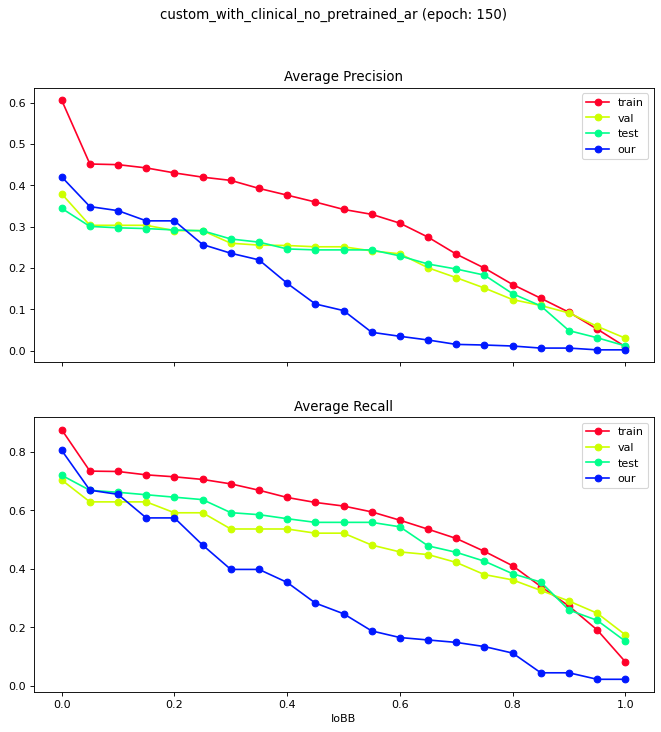

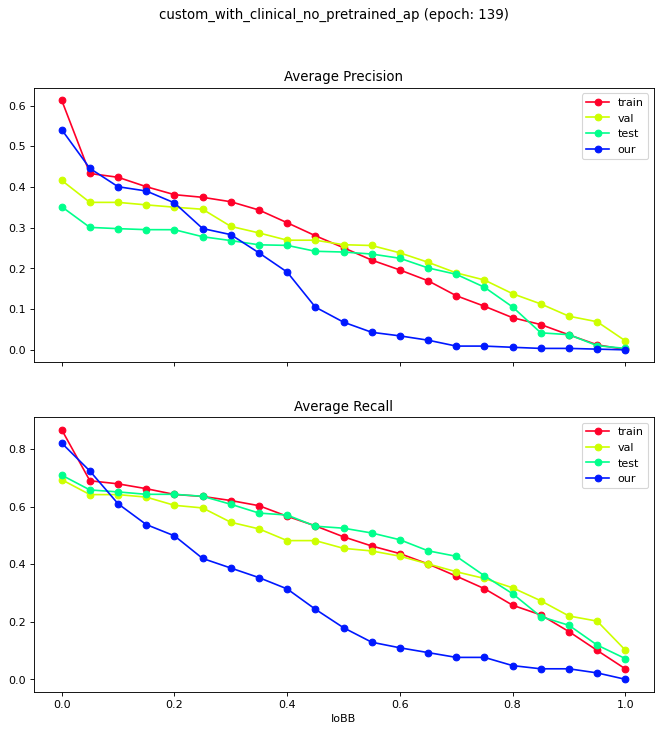

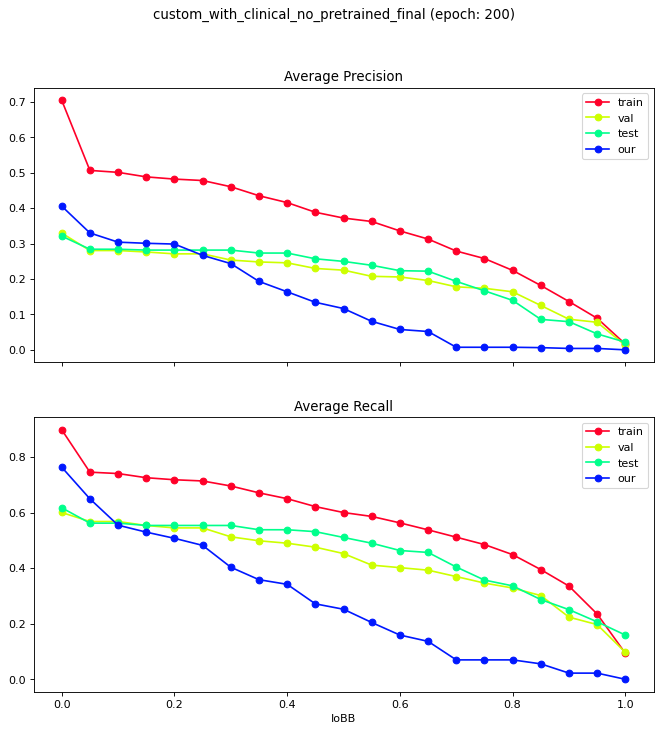

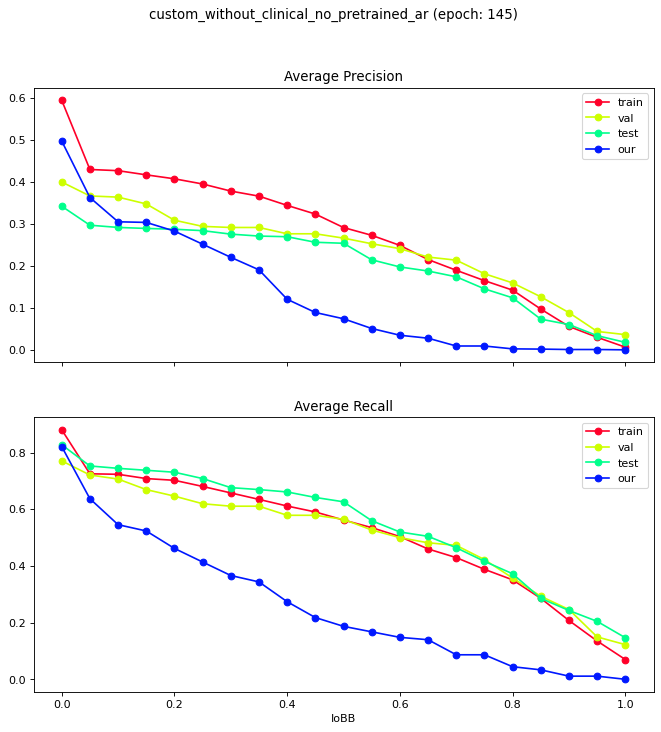

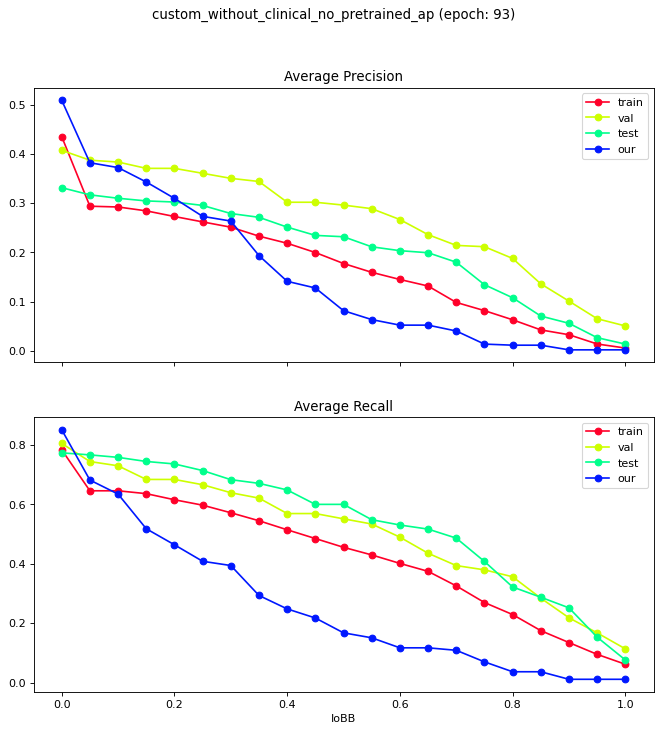

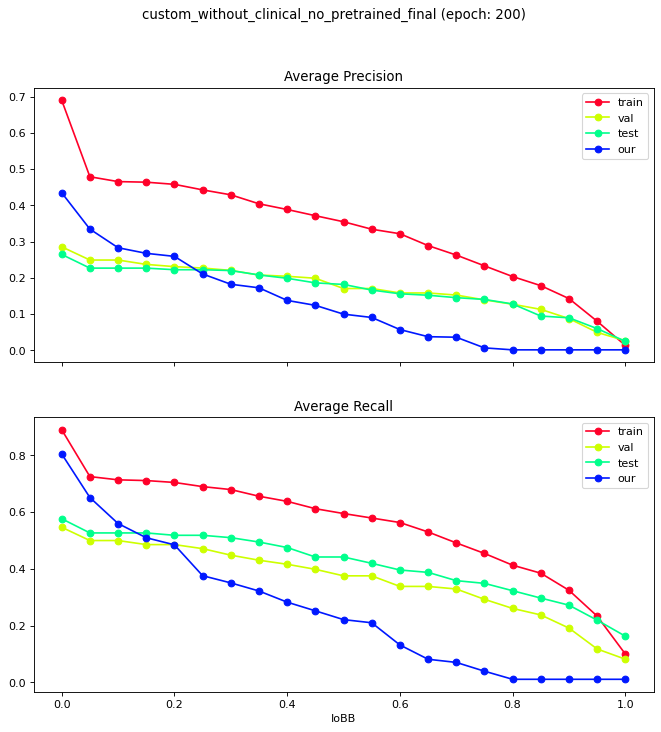

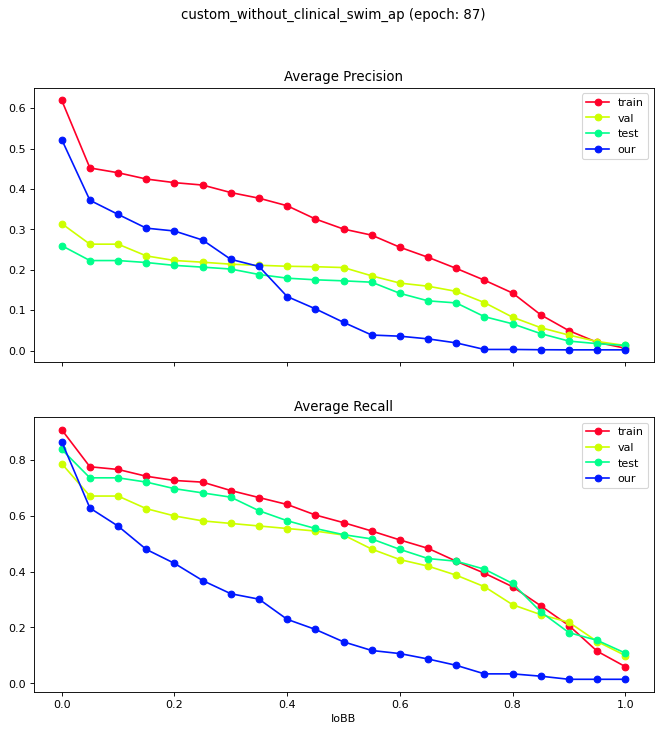

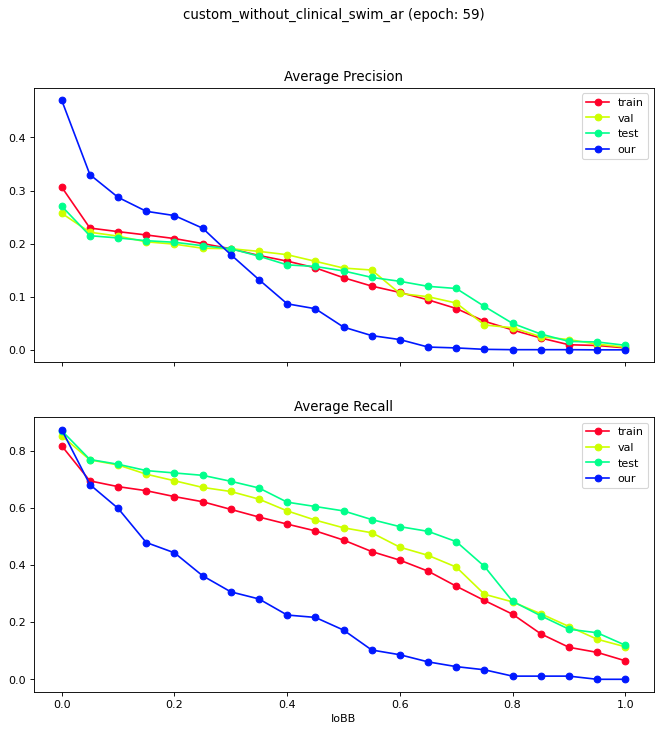

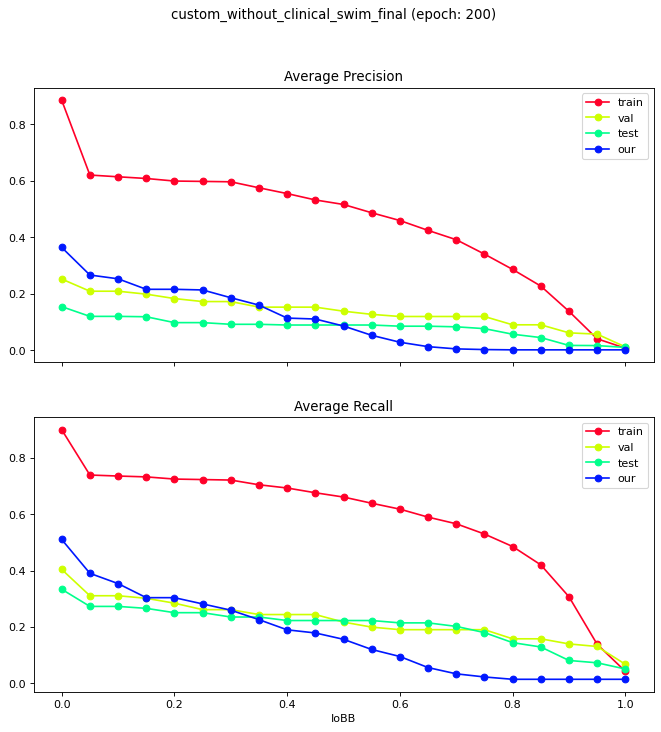

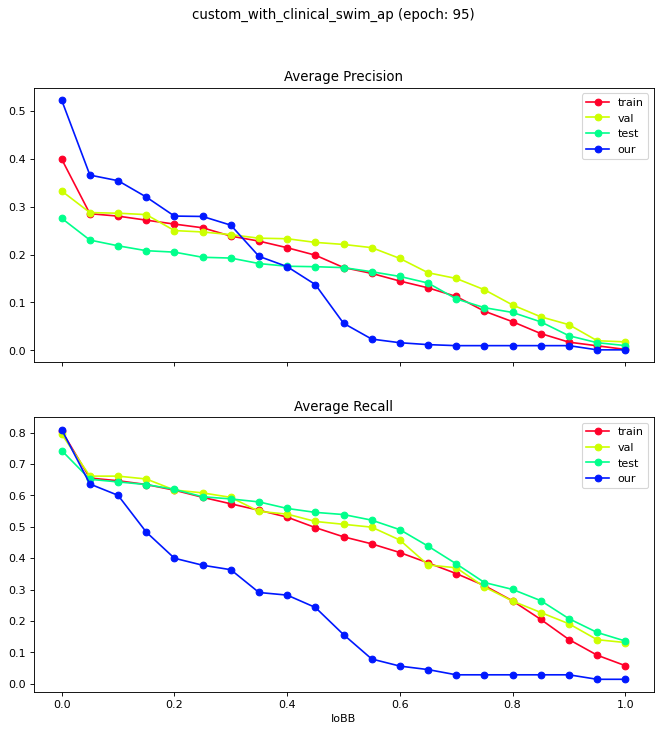

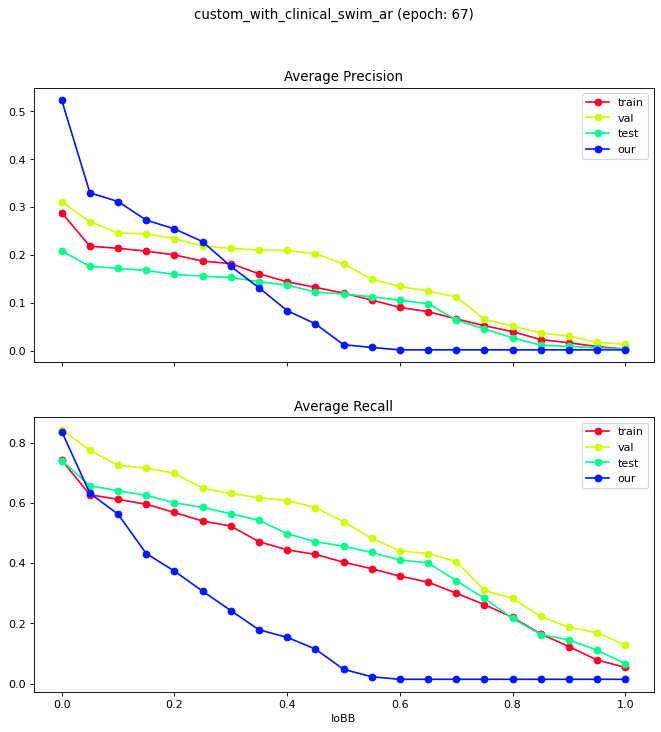

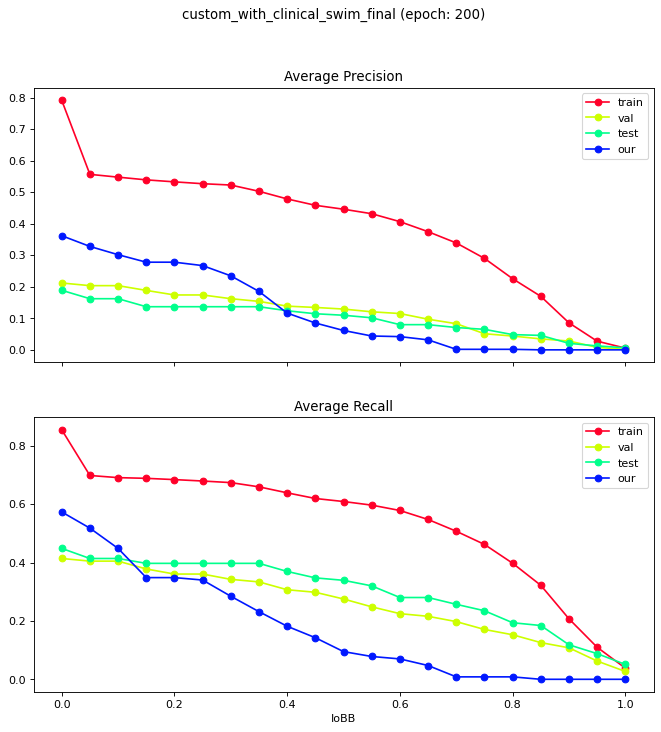

In [16]:
for select_model in TrainedModels:
    _= showModelOnDatasets(
        select_model=select_model,
        datasets=['train','val', 'test', 'our'],
        disease='all',
    )

In [ ]:
# test if everyone feature can be predictable, then we know that the additional clincalNet.

In [18]:
all_ap_models = [
    TrainedModels.custom_with_clinical_swim_ap,
    TrainedModels.custom_without_clinical_swim_ap,
    TrainedModels.custom_with_clinical_no_pretrained_ap,
    TrainedModels.custom_without_clinical_no_pretrained_ap
]

all_ar_models = [
    TrainedModels.custom_with_clinical_swim_ar,
    TrainedModels.custom_without_clinical_swim_ar,
    TrainedModels.custom_with_clinical_no_pretrained_ar,
    TrainedModels.custom_without_clinical_no_pretrained_ar,
]

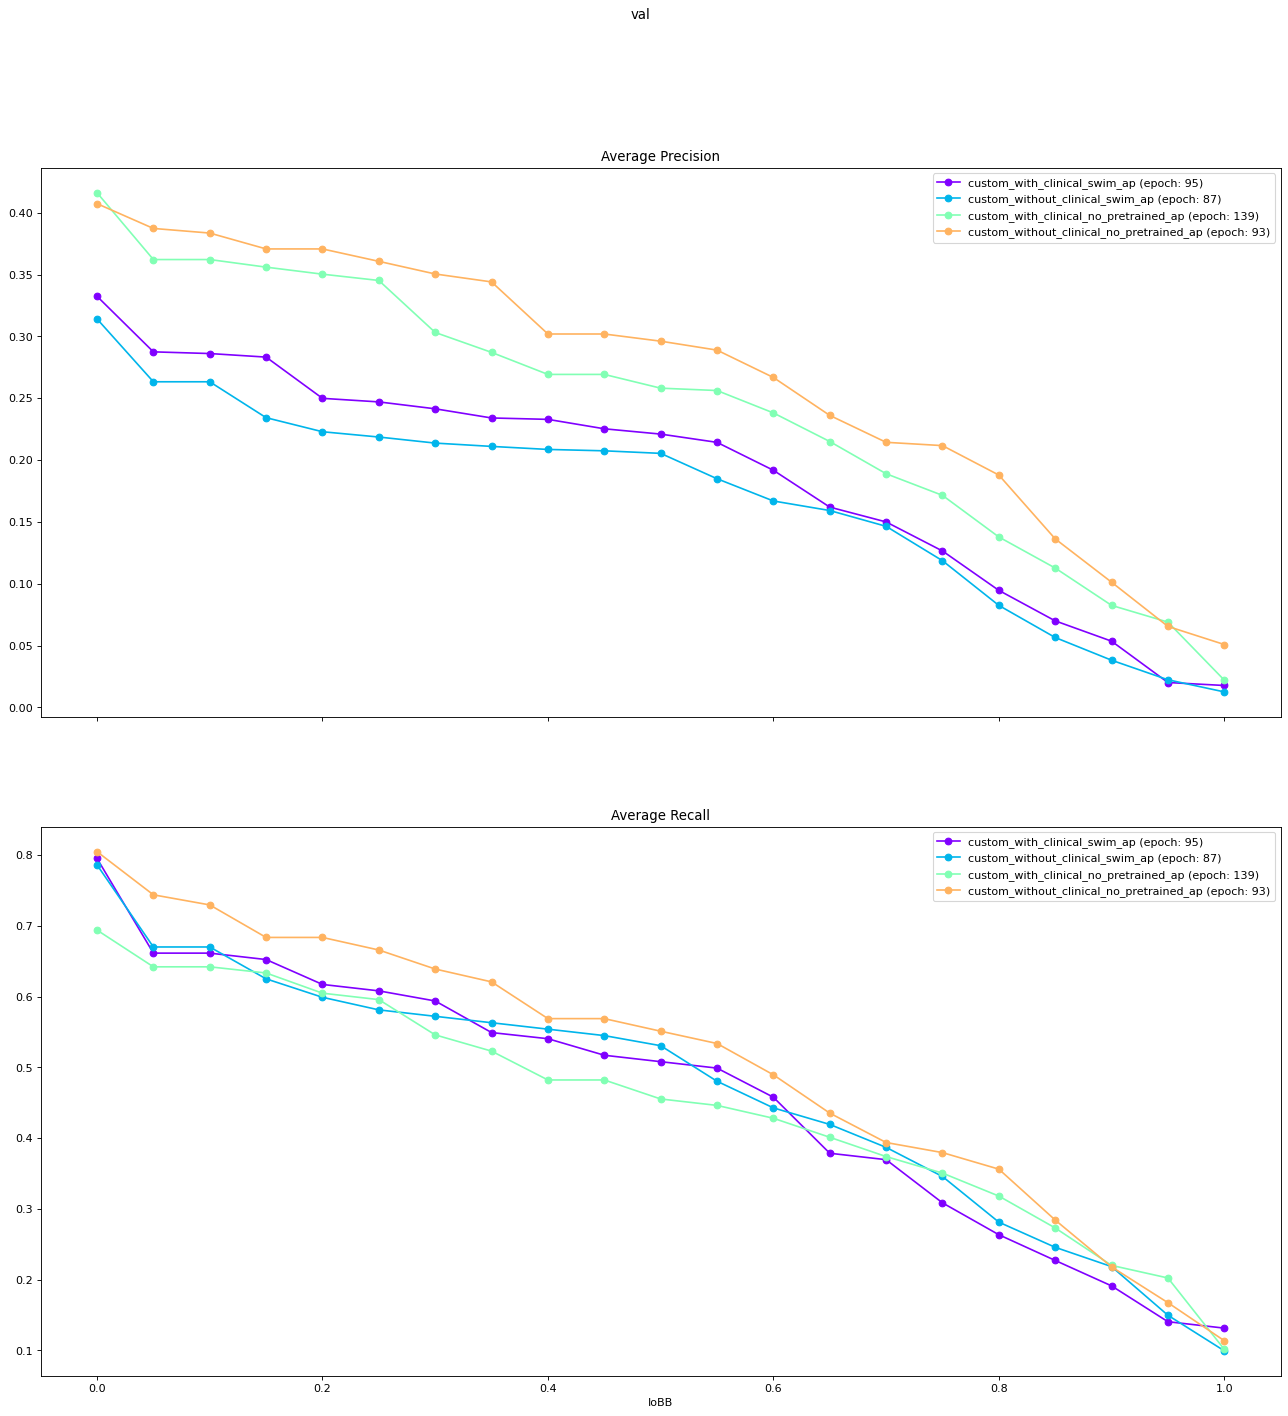

In [22]:
_ = plot_iou_result(all_ap_models, "val", figsize=(20, 20))

# In the validation dataset:
# 1. ResNet50 perform better than the Swin Backbone.
# 2. without clinical > with clinical.

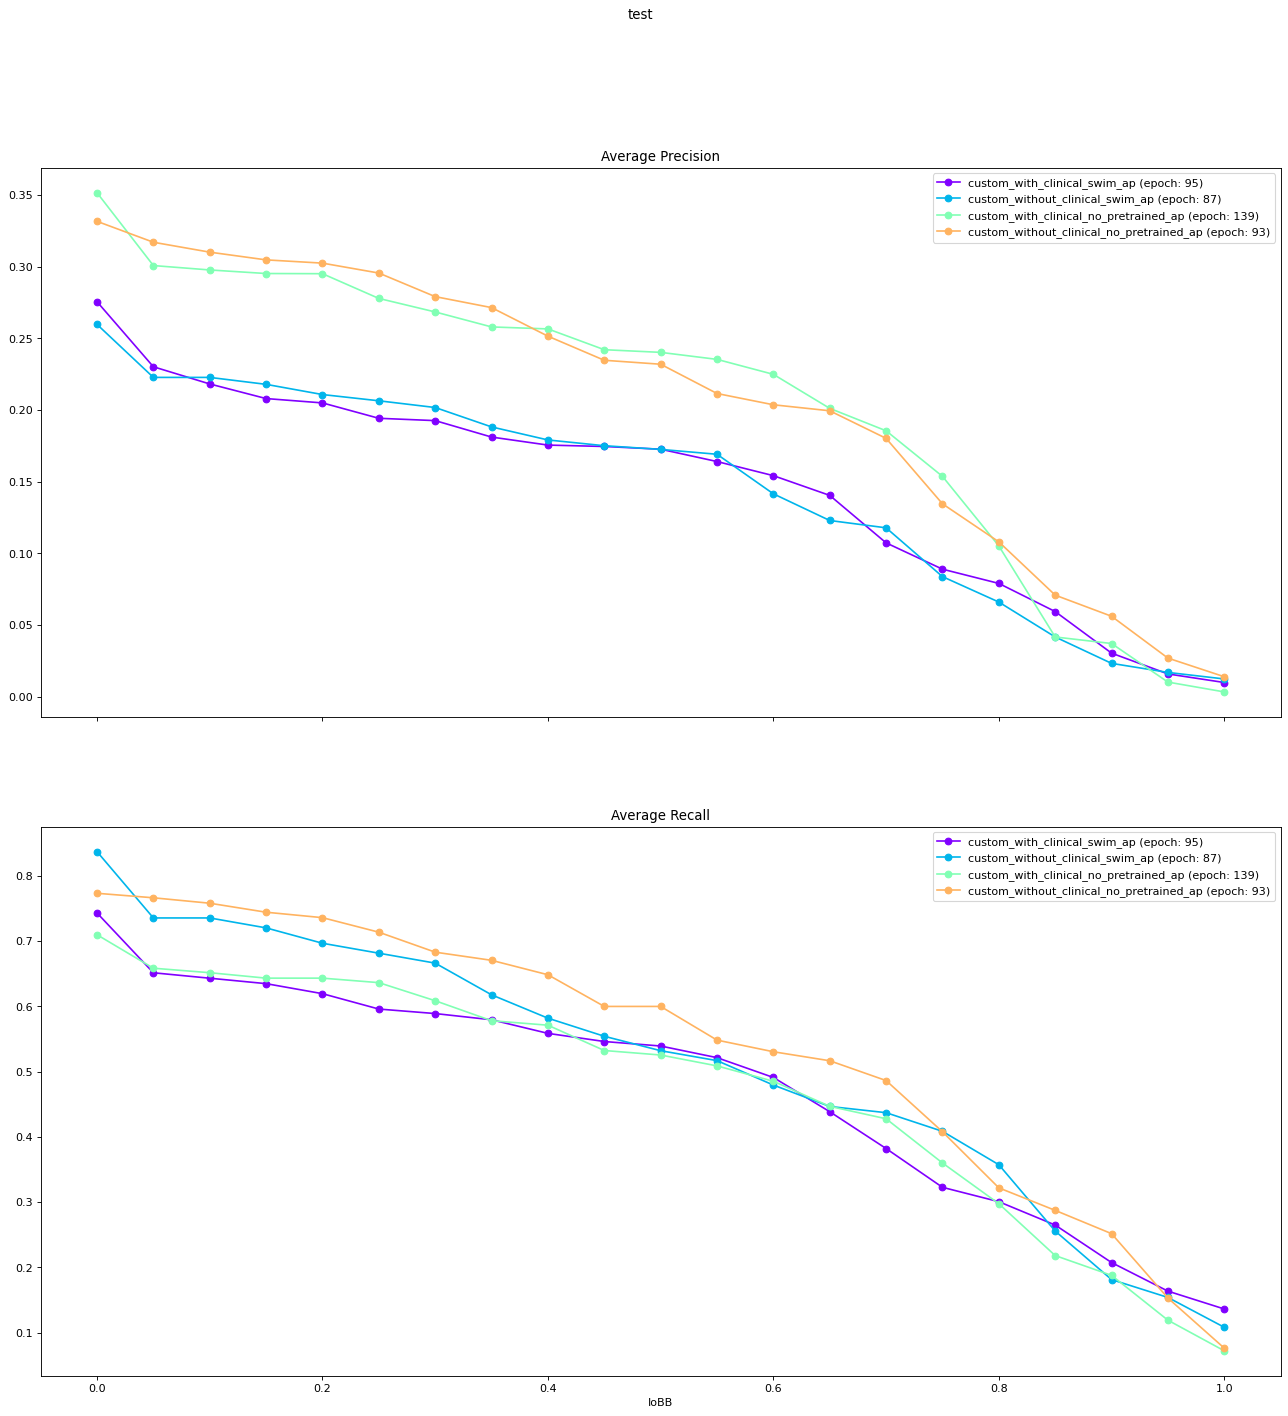

In [23]:
_ = plot_iou_result(all_ap_models, "test", figsize=(20, 20))

# In the test dataset:
# 1. ResNet50 perform better than the Swin Backbone.
# 2. the result in pretty close.

## Comparing pretrained and no pretrained model in with no clinical data circumstance.

In [17]:
pretrained_and_no_pretrained_without_clinical = [
    TrainedModels.custom_without_clinical_pretrained_ar,
    TrainedModels.custom_without_clinical_pretrained_ap,
    TrainedModels.custom_without_clinical_pretrained_final,
    TrainedModels.custom_without_clinical_no_pretrained_ar,
    TrainedModels.custom_without_clinical_no_pretrained_ap,
    TrainedModels.custom_without_clinical_no_pretrained_final,
]

_ = plot_iou_result(
    pretrained_and_no_pretrained_without_clinical, "train", figsize=(20, 20)
)
_ = plot_iou_result(
    pretrained_and_no_pretrained_without_clinical, "val", figsize=(20, 20)
)
_ = plot_iou_result(
    pretrained_and_no_pretrained_without_clinical, "test", figsize=(20, 20)
)
_ = plot_iou_result(
    pretrained_and_no_pretrained_without_clinical, "our", figsize=(20, 20)
)

# pretrained model fit the dataset the best. (if train for more epoch.)
# pretrained ar ap model work best on test and validatoin dataset

AttributeError: custom_without_clinical_pretrained_ar

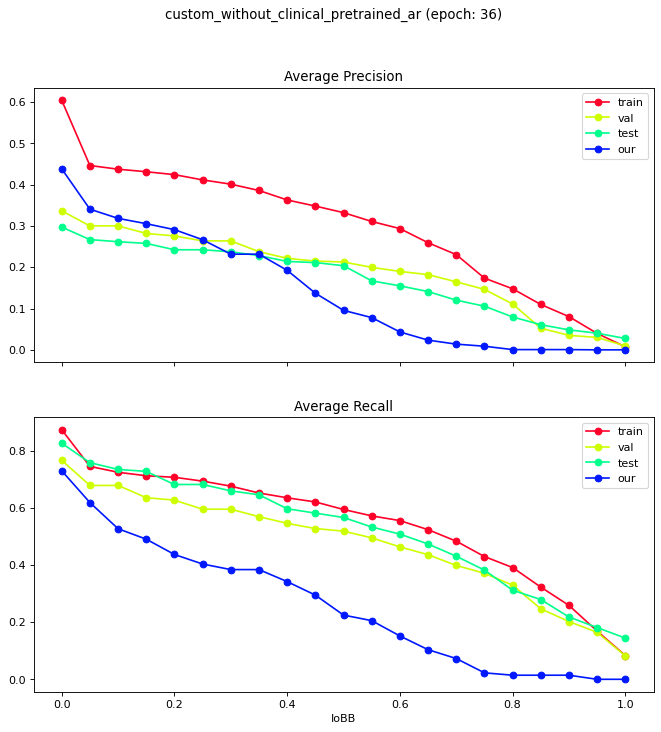

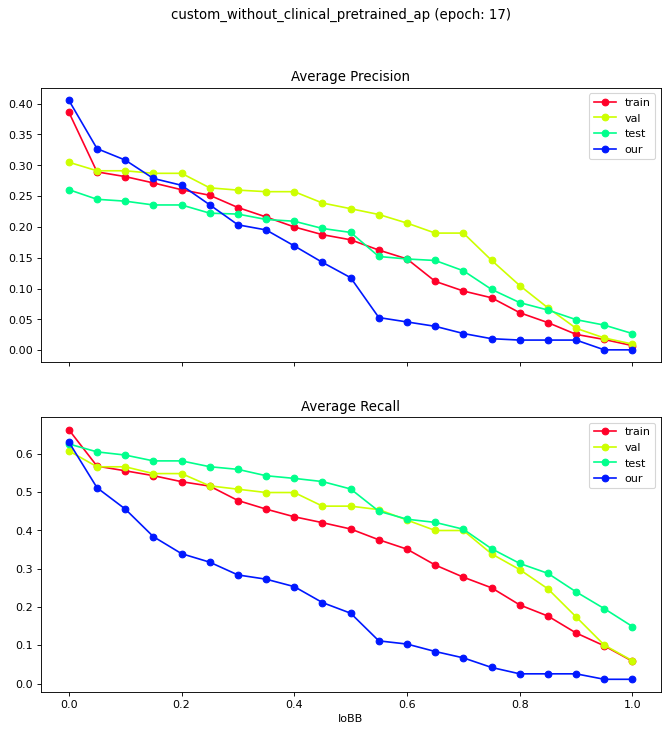

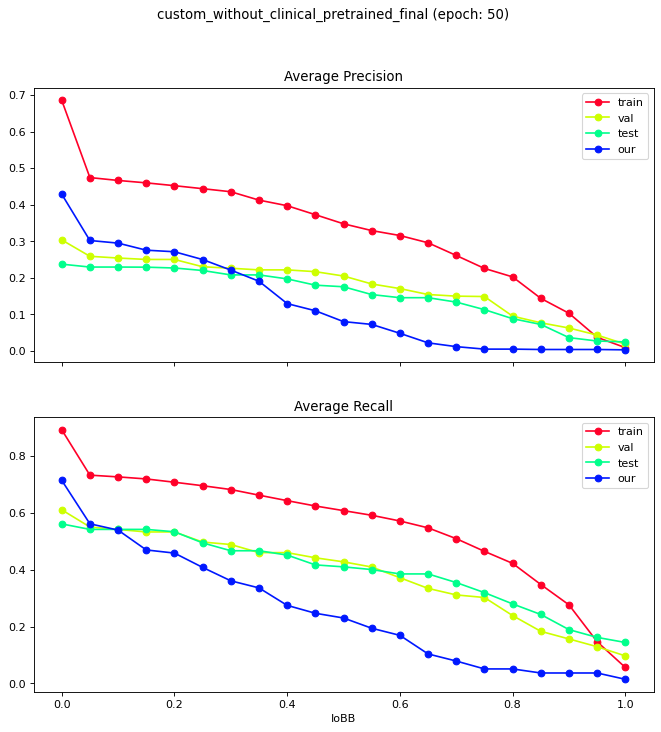

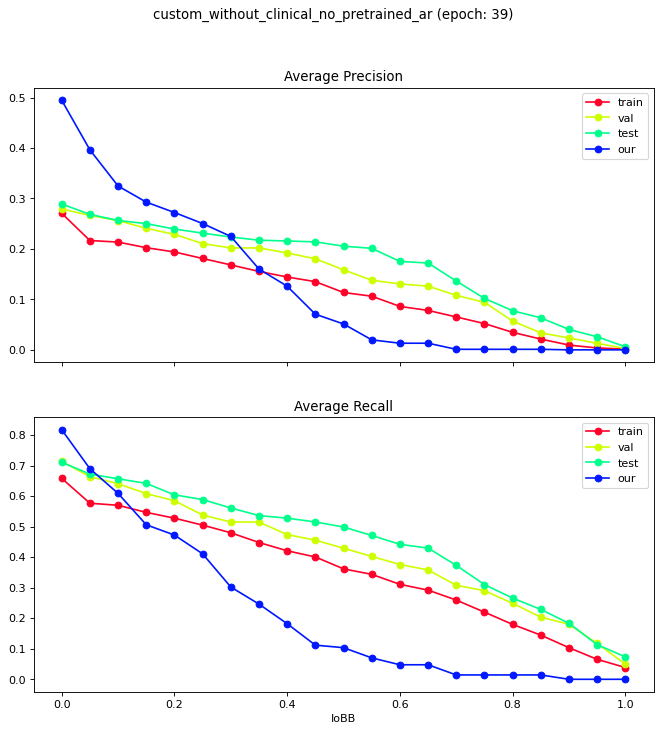

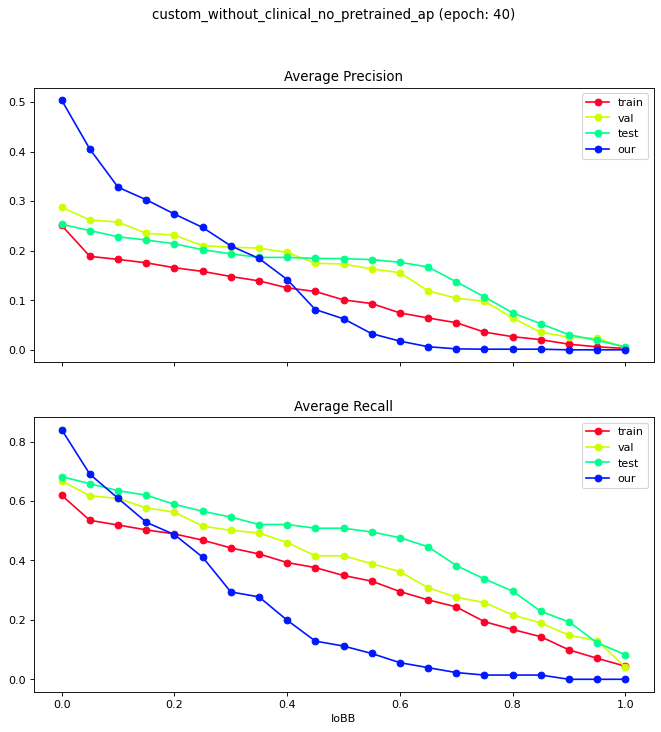

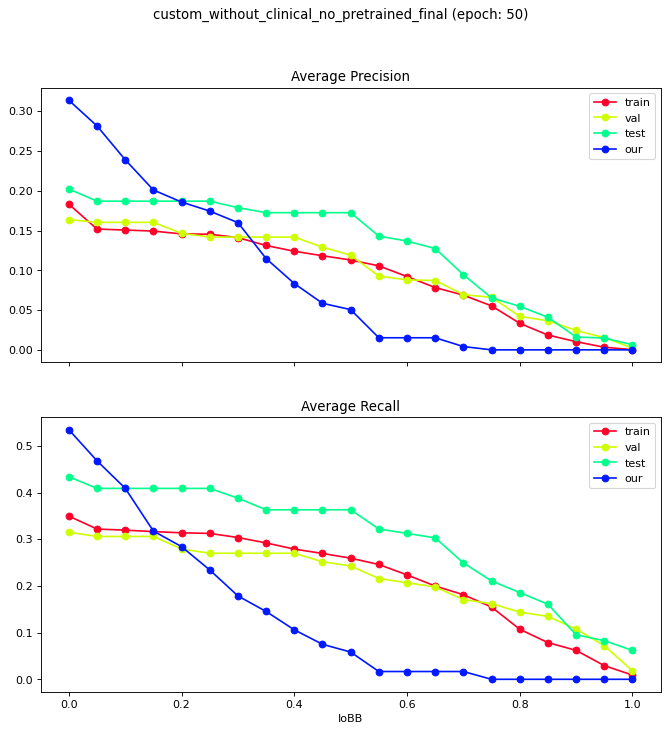

In [ ]:
# Q: pretrained and unpretrained models, which one has a worse overfitting issue?

for select_model in pretrained_and_no_pretrained_without_clinical:
    _ = showModelOnDatasets(
        select_model=select_model,
        datasets=["train", "val", "test", "our"],
        disease="all",
    )

# Found:
# the unpretrained model has less overfitting; however, the it may means that the model just need more epochs to converge.

# **Q:** Comparing Swin and ResNet50, which backbone is better when we just train for 50 epoch.

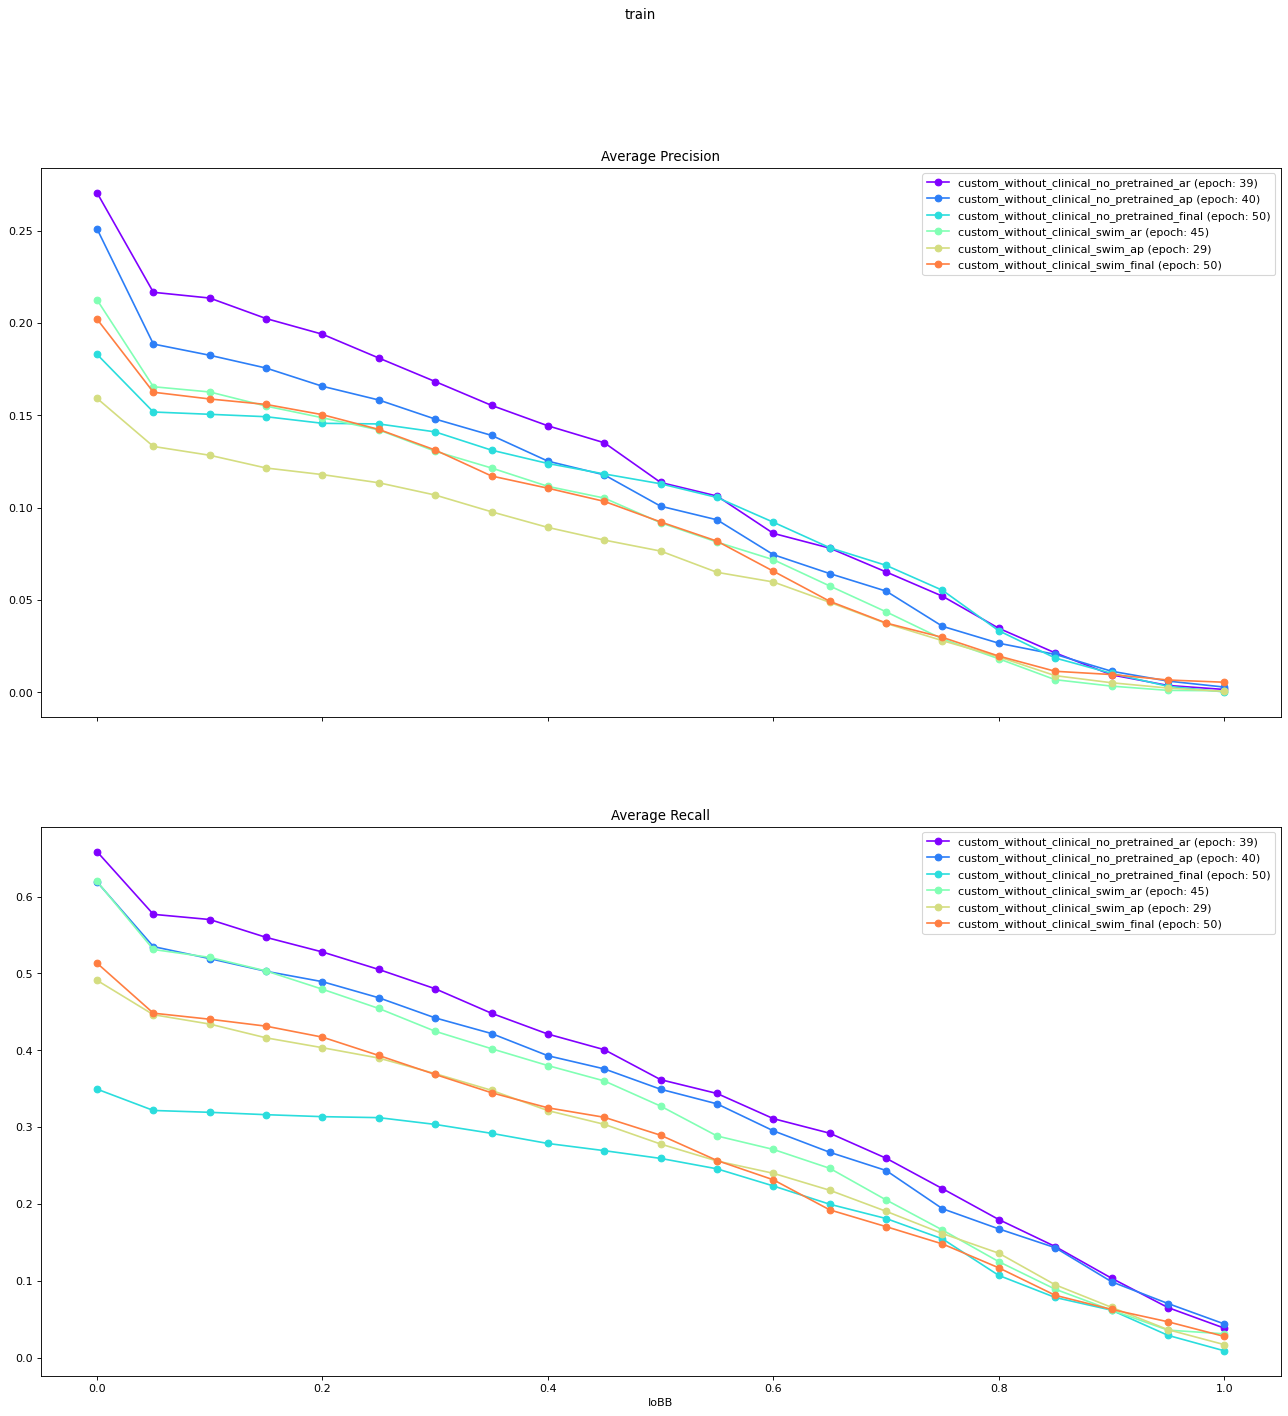

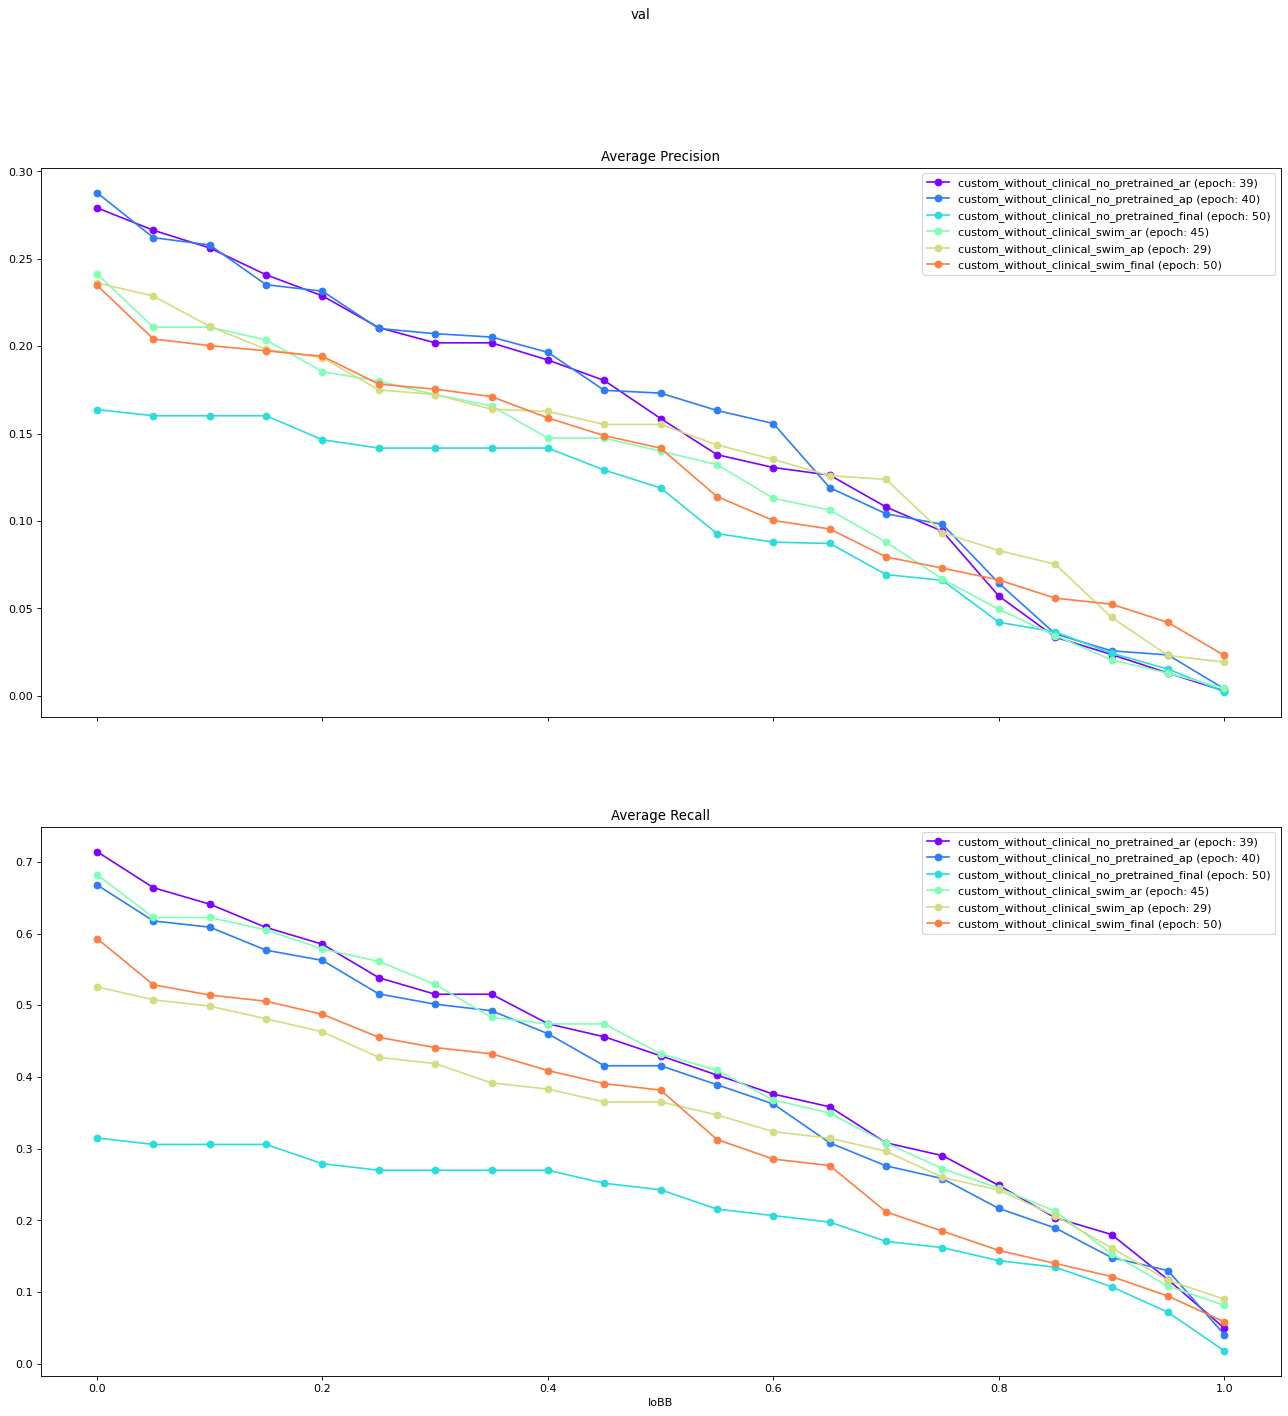

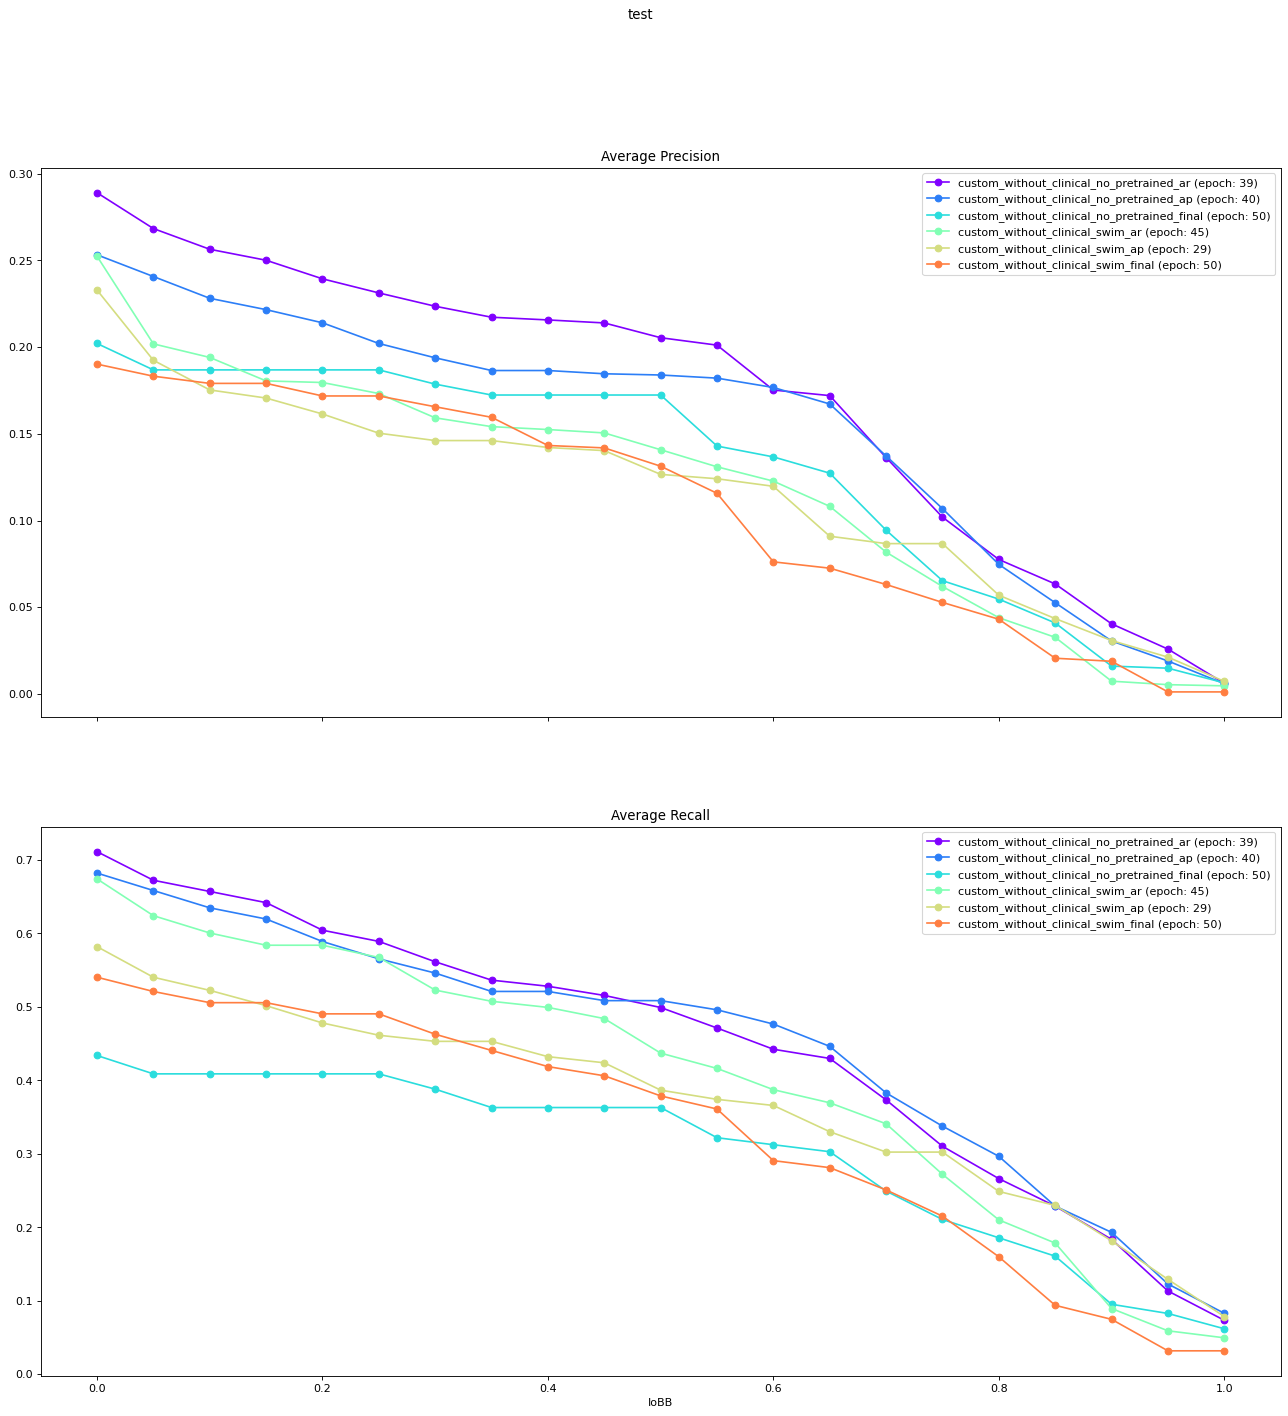

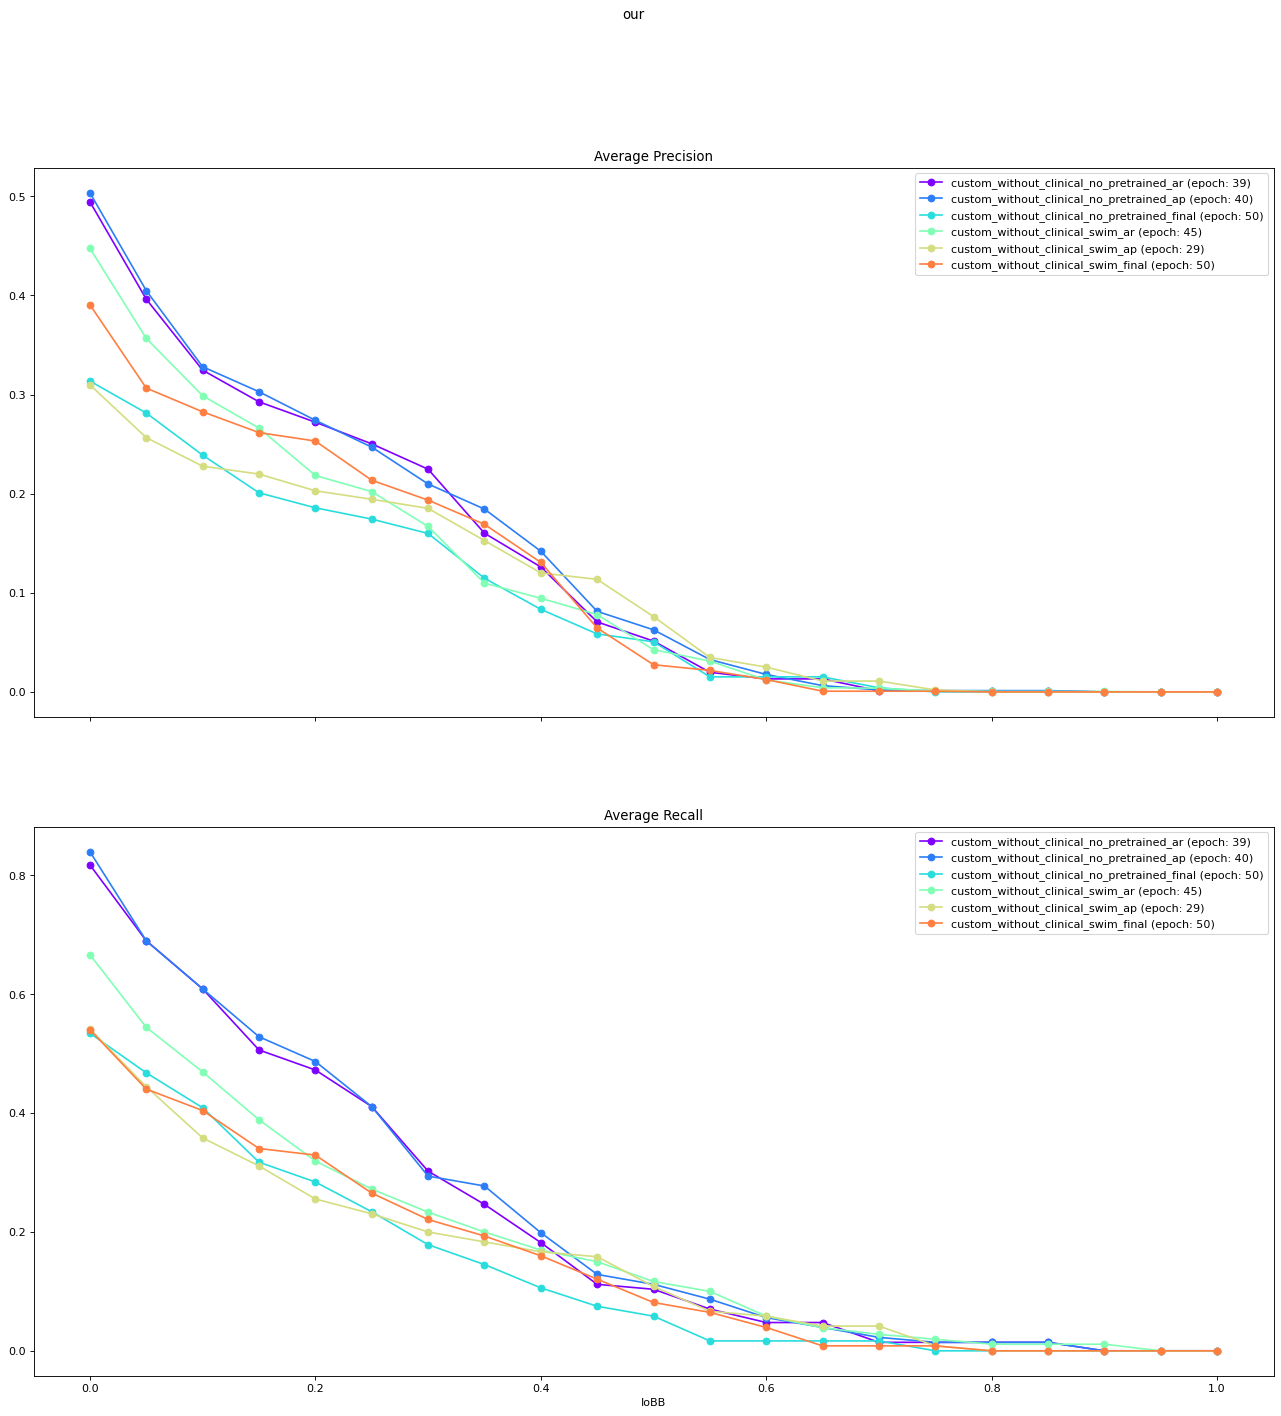

In [ ]:
swin_and_resnet_models_clinical = [
    TrainedModels.custom_without_clinical_no_pretrained_ar,
    TrainedModels.custom_without_clinical_no_pretrained_ap,
    TrainedModels.custom_without_clinical_no_pretrained_final,

    TrainedModels.custom_without_clinical_swim_ar,
    TrainedModels.custom_without_clinical_swim_ap,
    TrainedModels.custom_without_clinical_swim_final,
]

_ = plot_iou_result(
    swin_and_resnet_models_clinical, "train", figsize=(20, 20)
)
_ = plot_iou_result(
    swin_and_resnet_models_clinical, "val", figsize=(20, 20)
)
_ = plot_iou_result(
    swin_and_resnet_models_clinical, "test", figsize=(20, 20)
)
_ = plot_iou_result(
    swin_and_resnet_models_clinical, "our", figsize=(20, 20)
)

# Found:
# Swin converge latter than ResNet50, so the ResNet50 perform better than 

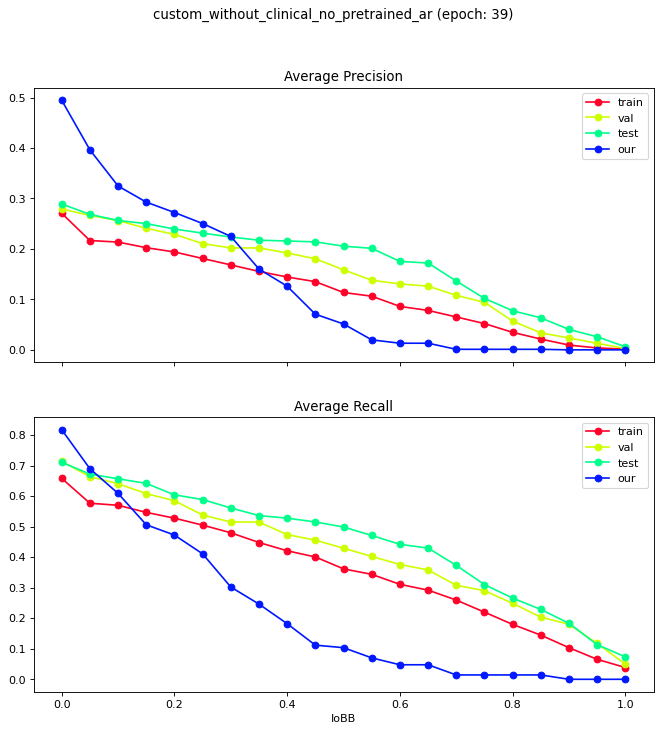

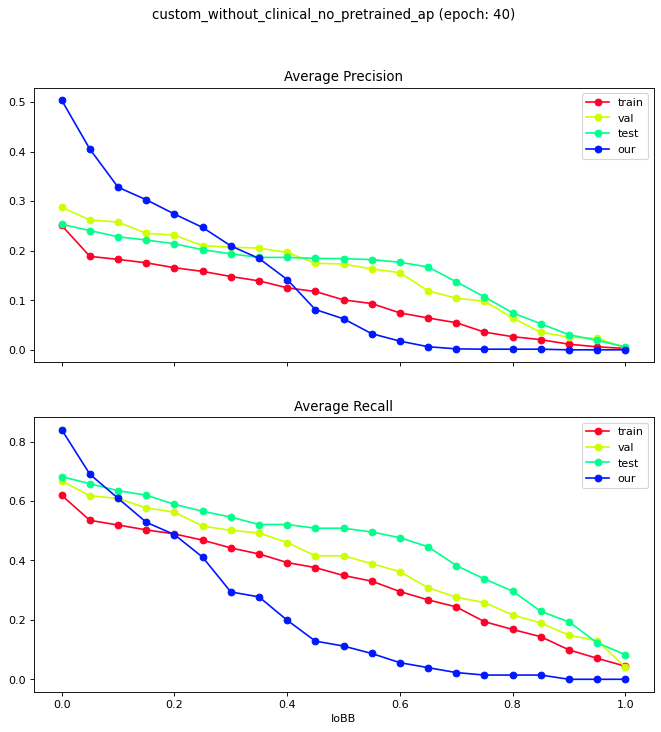

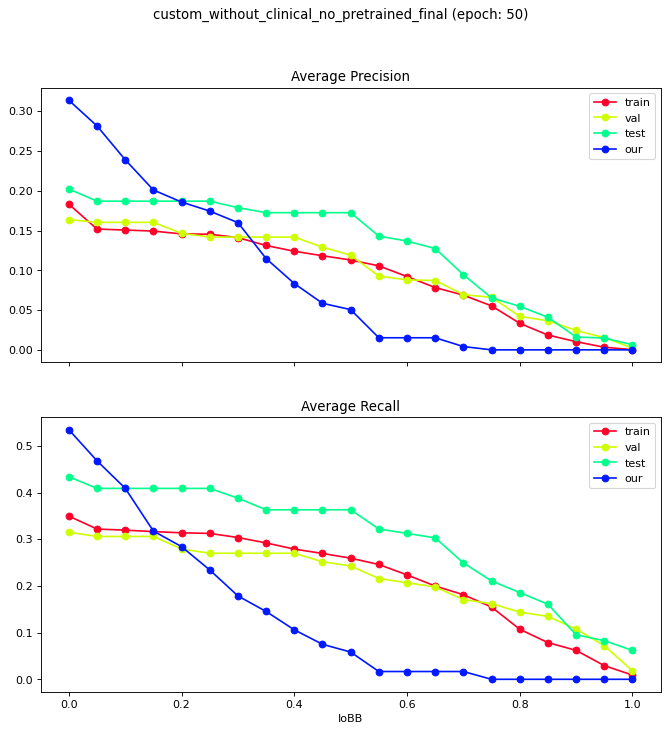

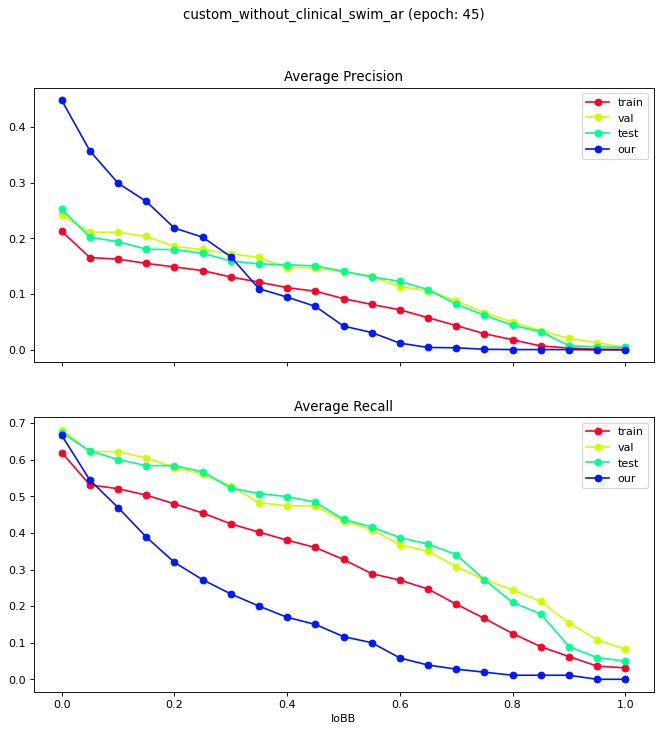

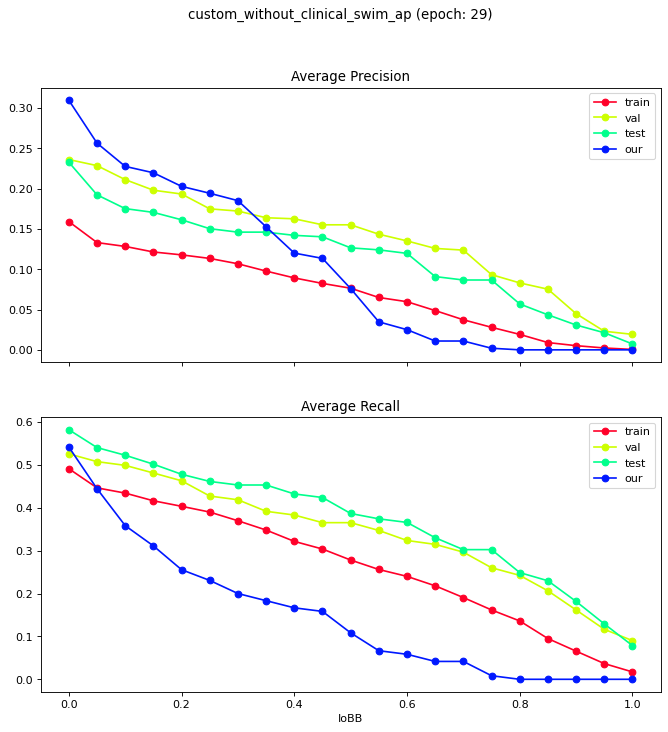

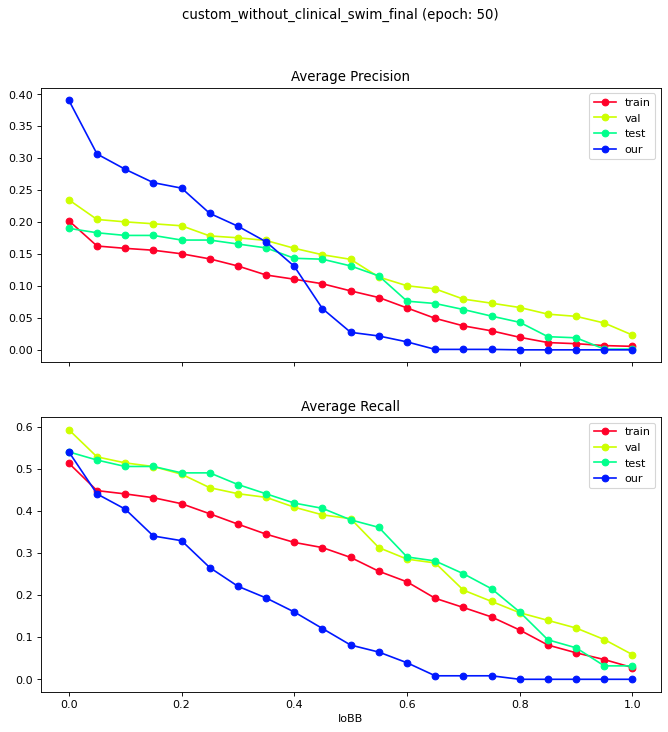

In [ ]:
for select_model in swin_and_resnet_models_clinical:
    _ = showModelOnDatasets(
        select_model=select_model,
        datasets=["train", "val", "test", "our"],
        disease="all",
    )

# **Q:** Compare with clinical and without clinical in pretrained model.

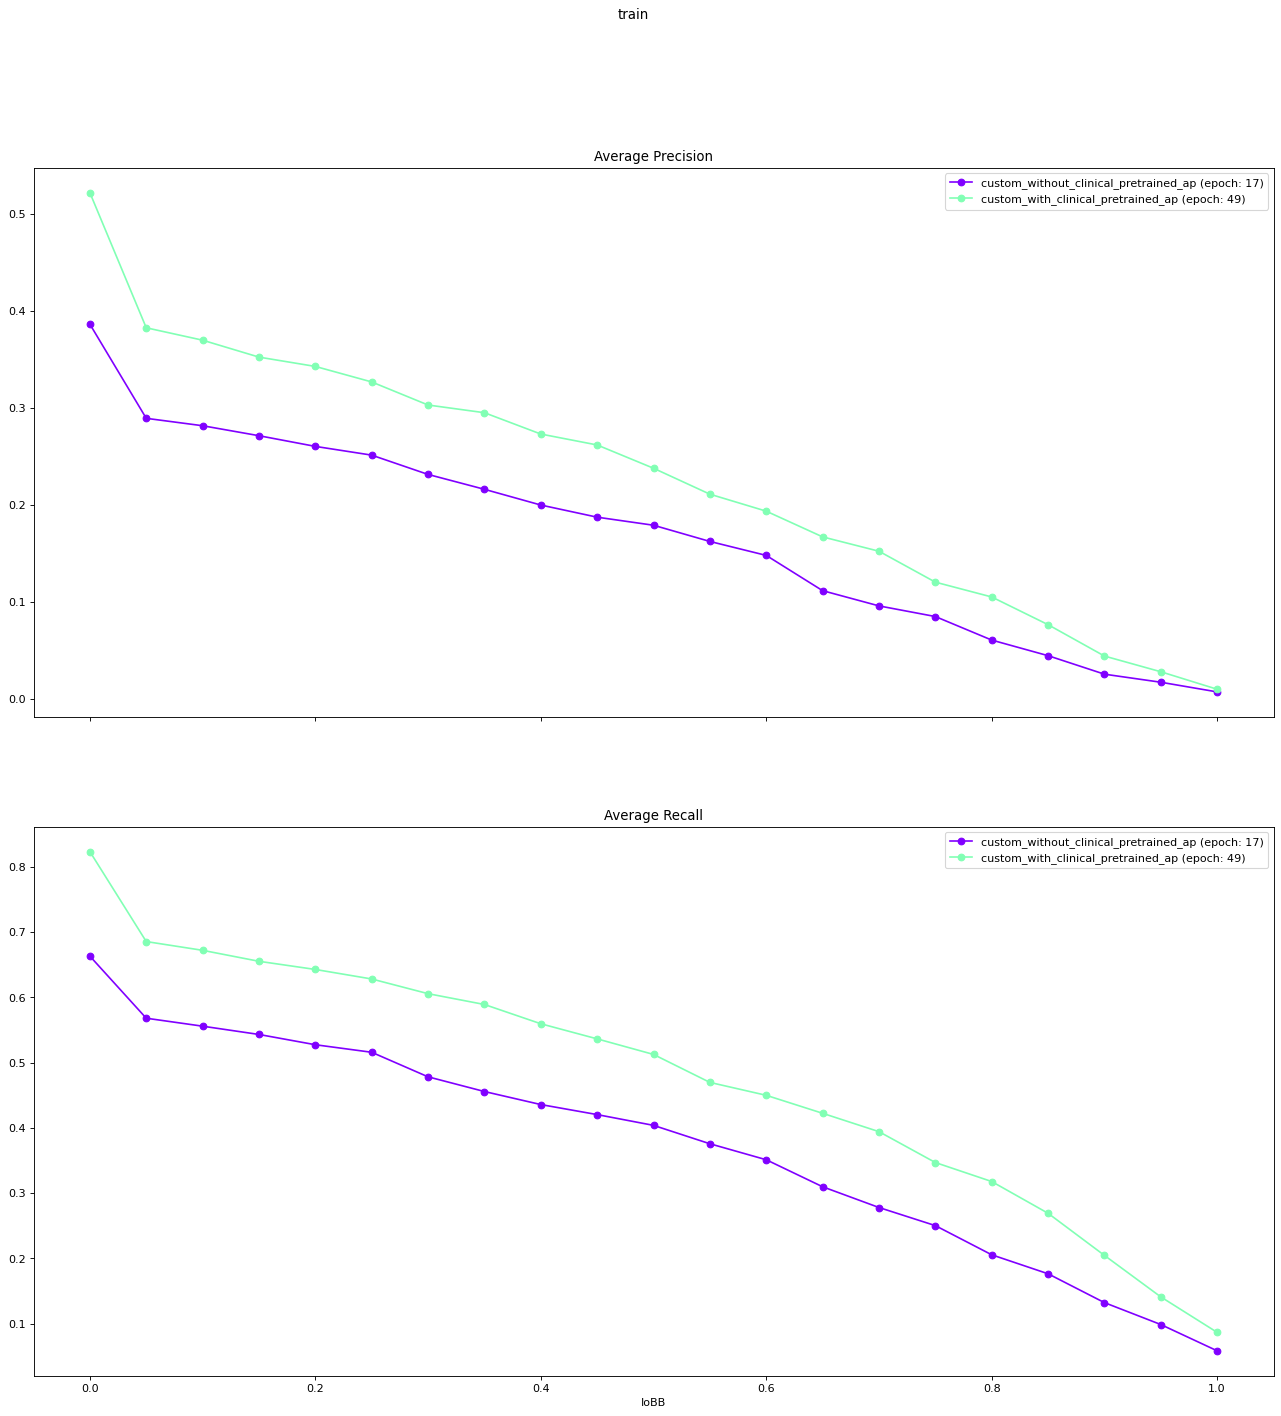

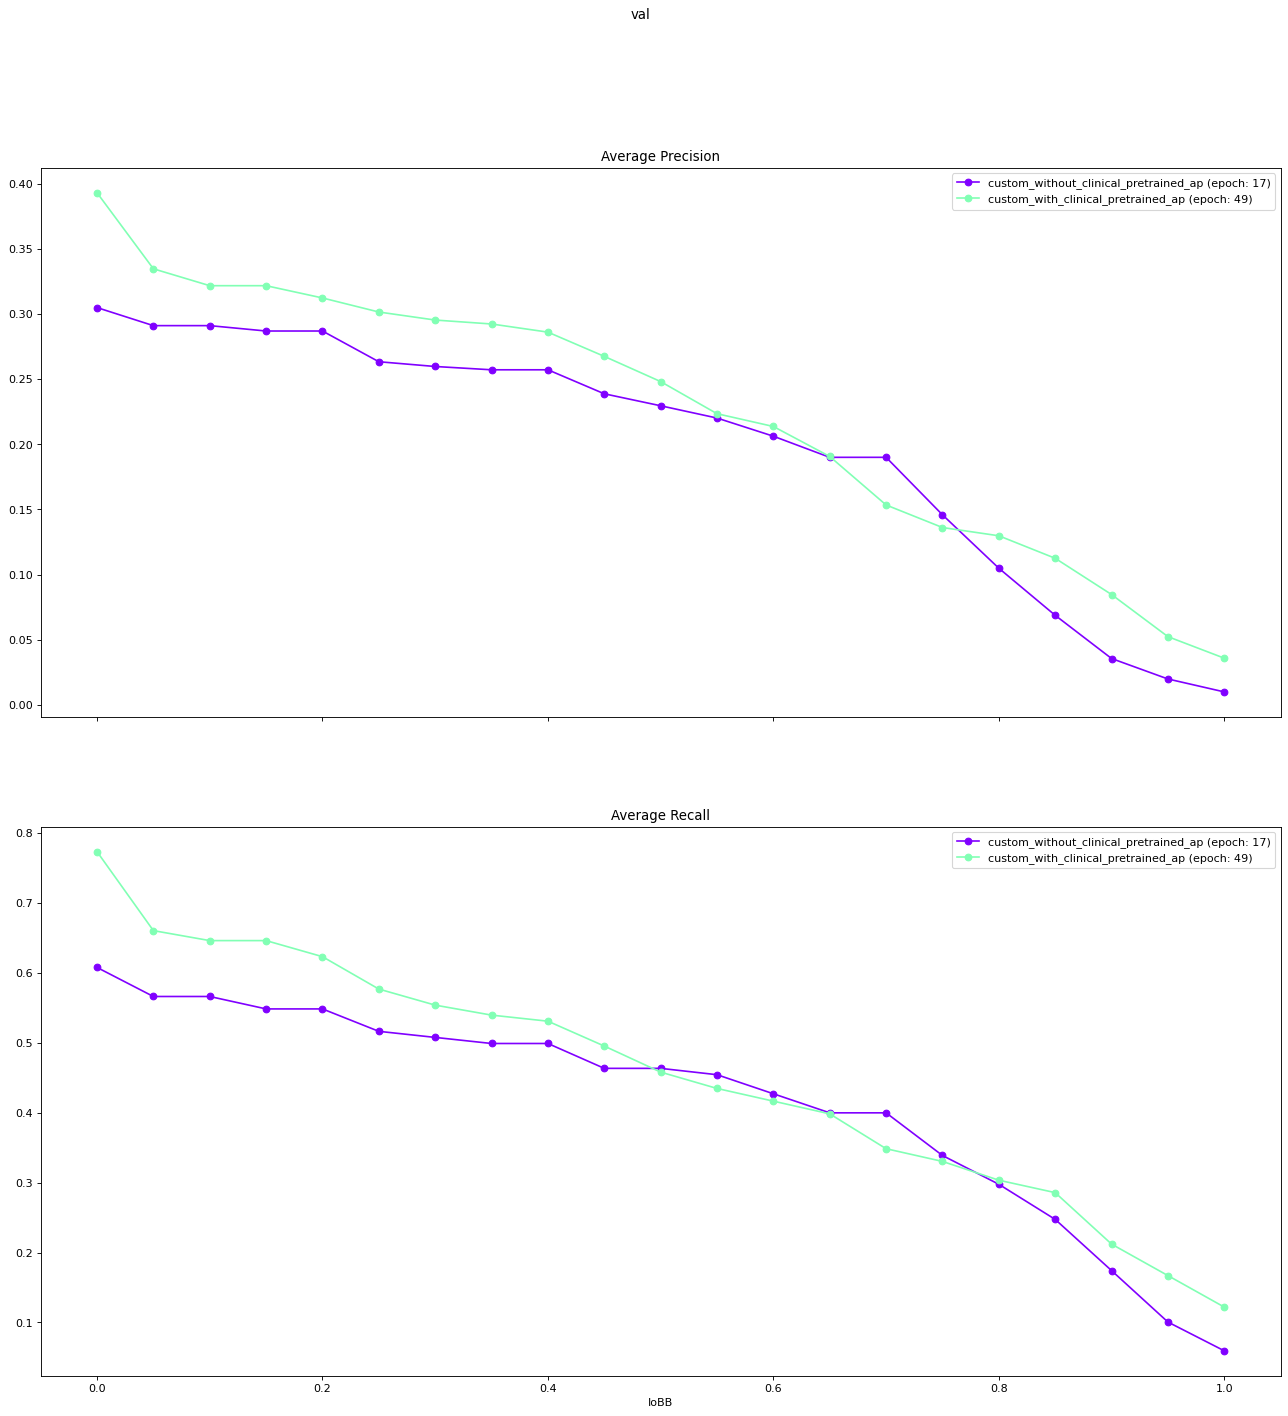

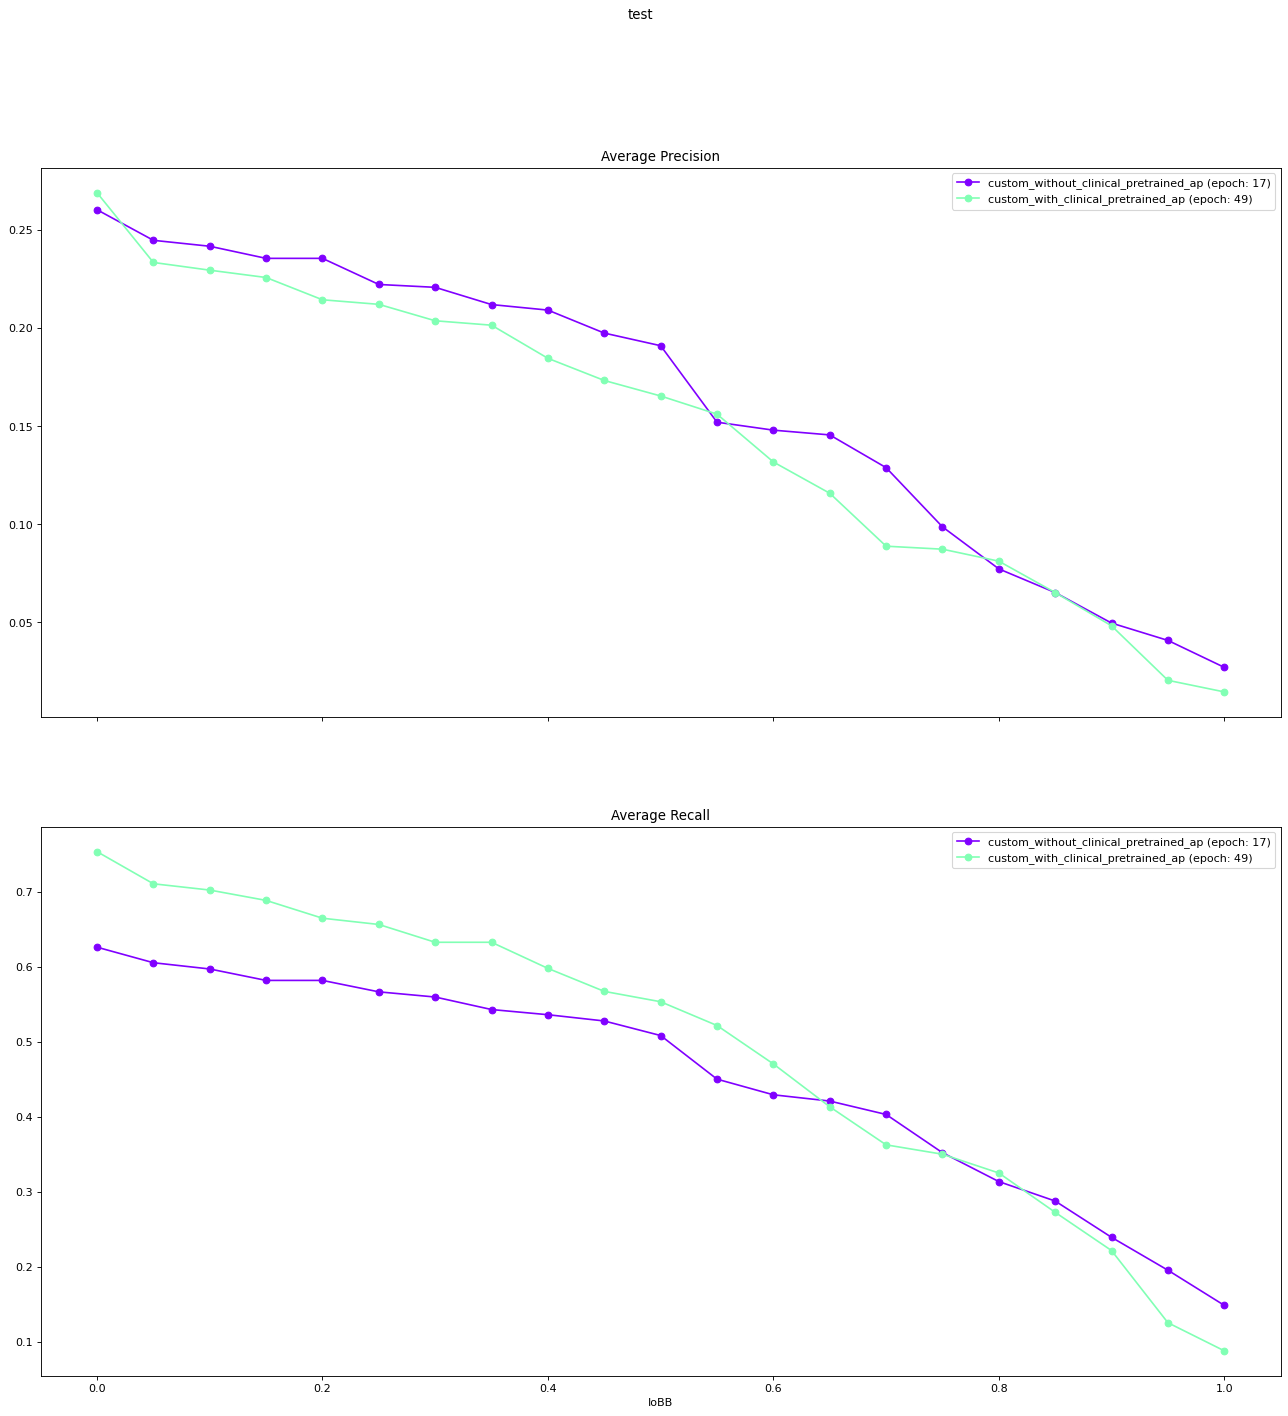

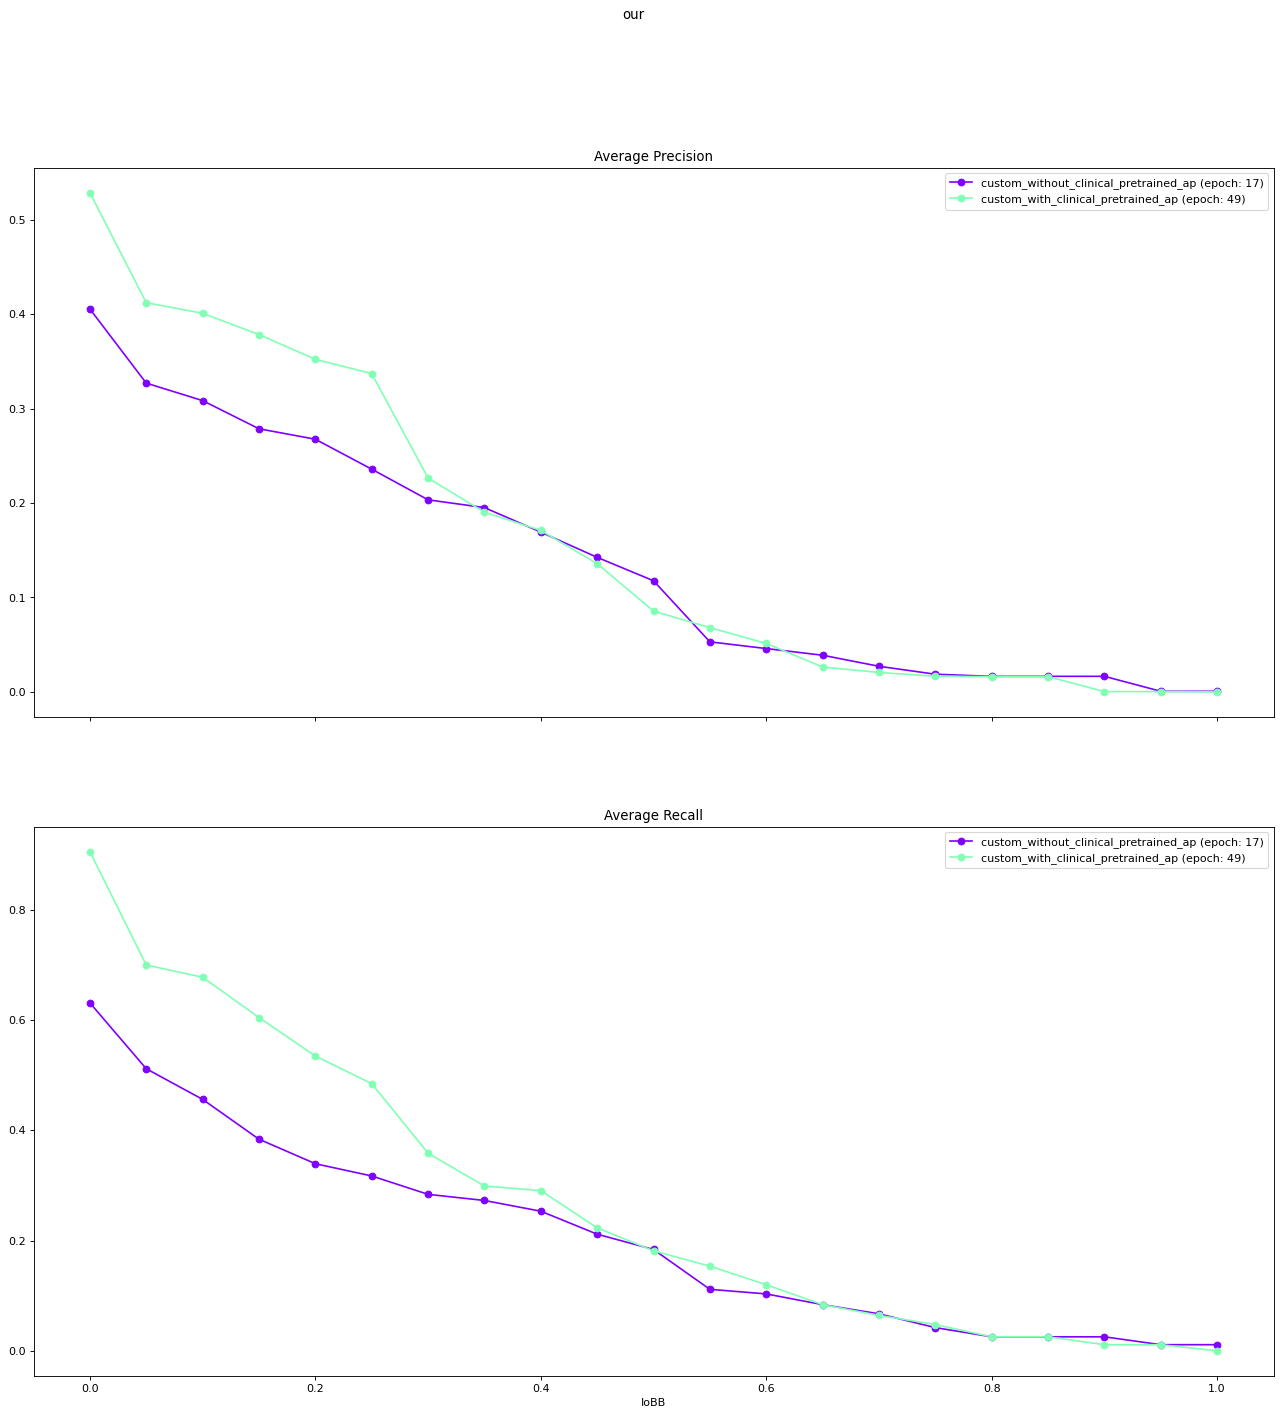

In [ ]:
# Q: with clinicla / without clinical, whihch is better in pretrained model. 

clinical_varialbe_in_pretrained = [
    # TrainedModels.custom_without_clinical_pretrained_ar,
    TrainedModels.custom_without_clinical_pretrained_ap,
    # TrainedModels.custom_without_clinical_pretrained_final,

    # TrainedModels.custom_with_clinical_pretrained_ar,
    TrainedModels.custom_with_clinical_pretrained_ap,
    # TrainedModels.custom_with_clinical_pretrained_final,
]

_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "train", figsize=(20, 20)
)
_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "val", figsize=(20, 20)
)
_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "test", figsize=(20, 20)
)
_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "our", figsize=(20, 20)
)


# with clincial is best in validation, but without clincal works better in test.

# Q: with clinicla / without clinical, whihch is better in unpretrained model. 


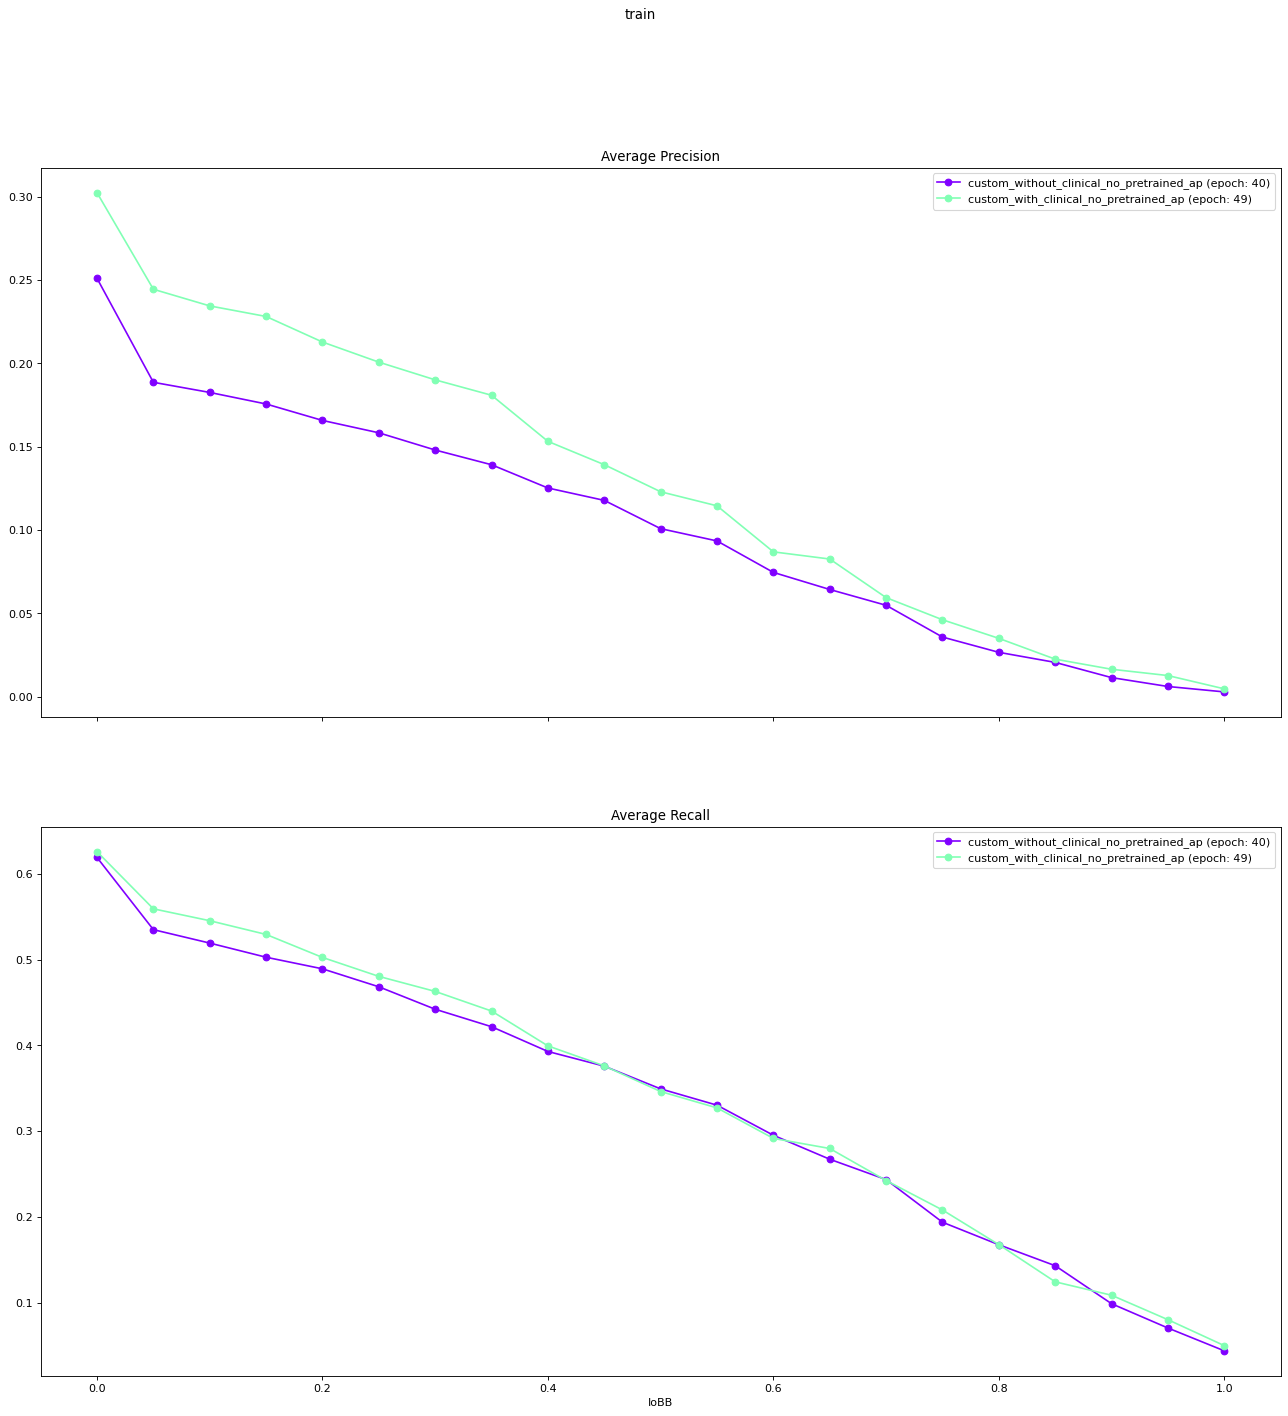

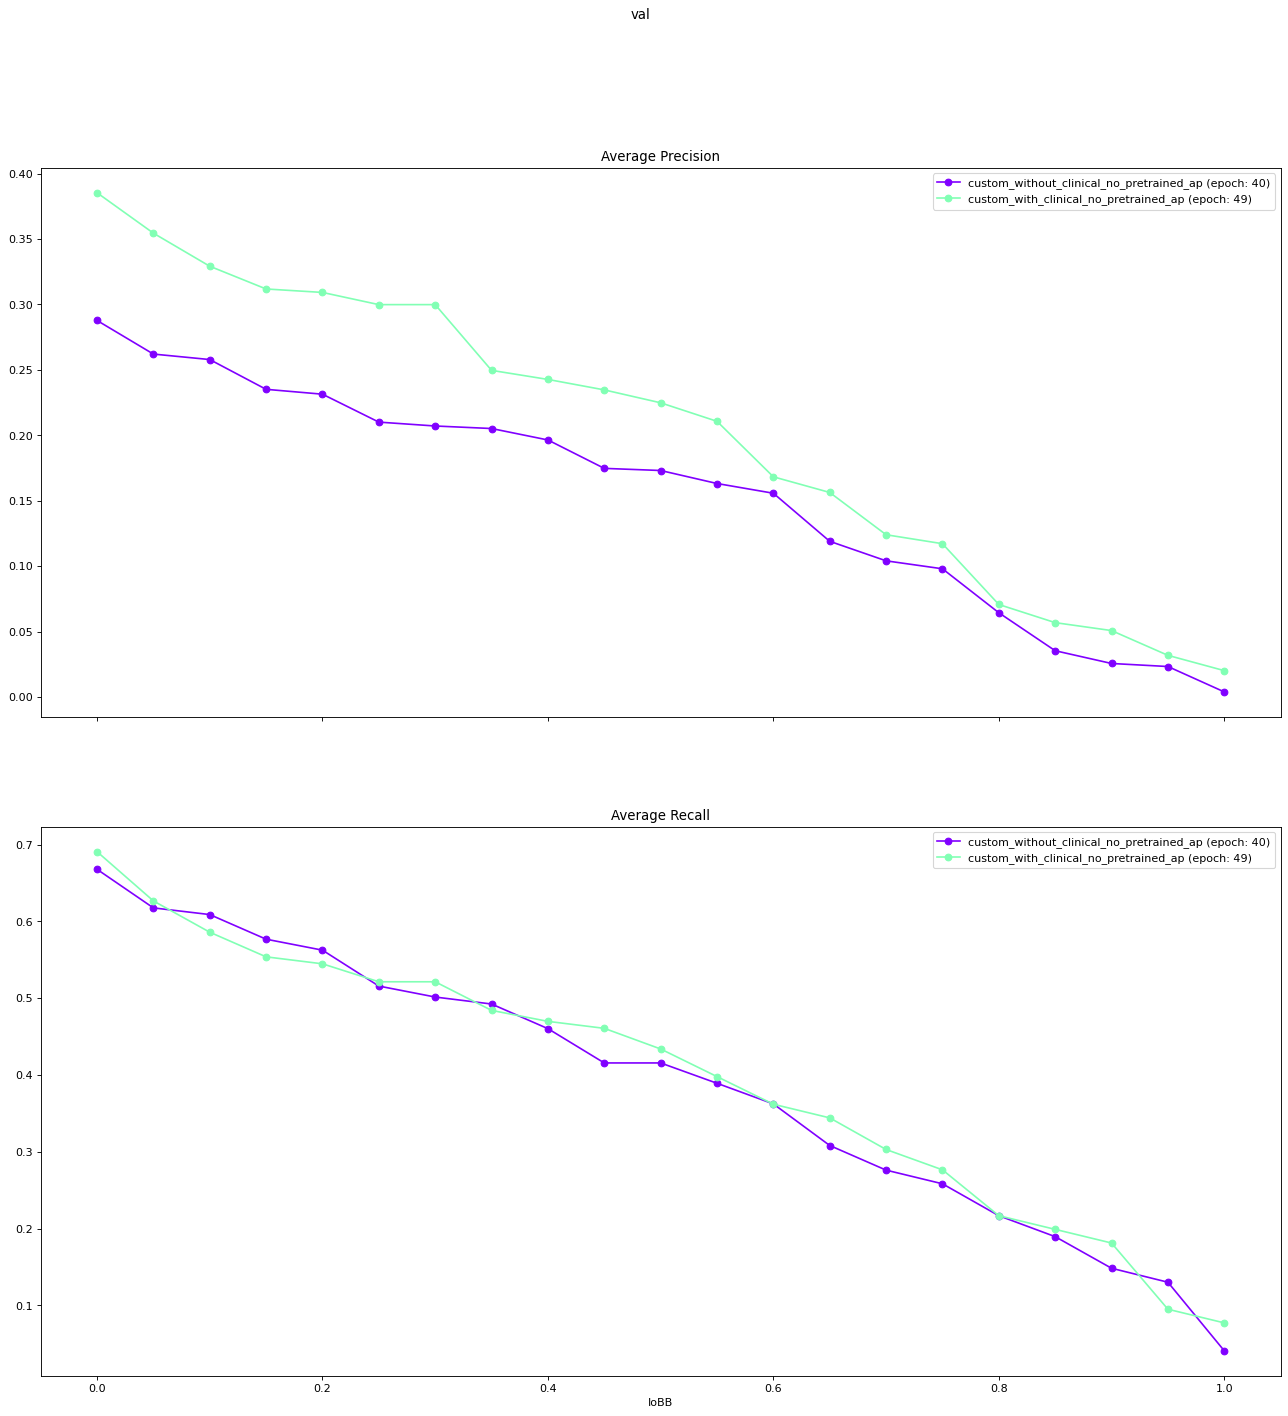

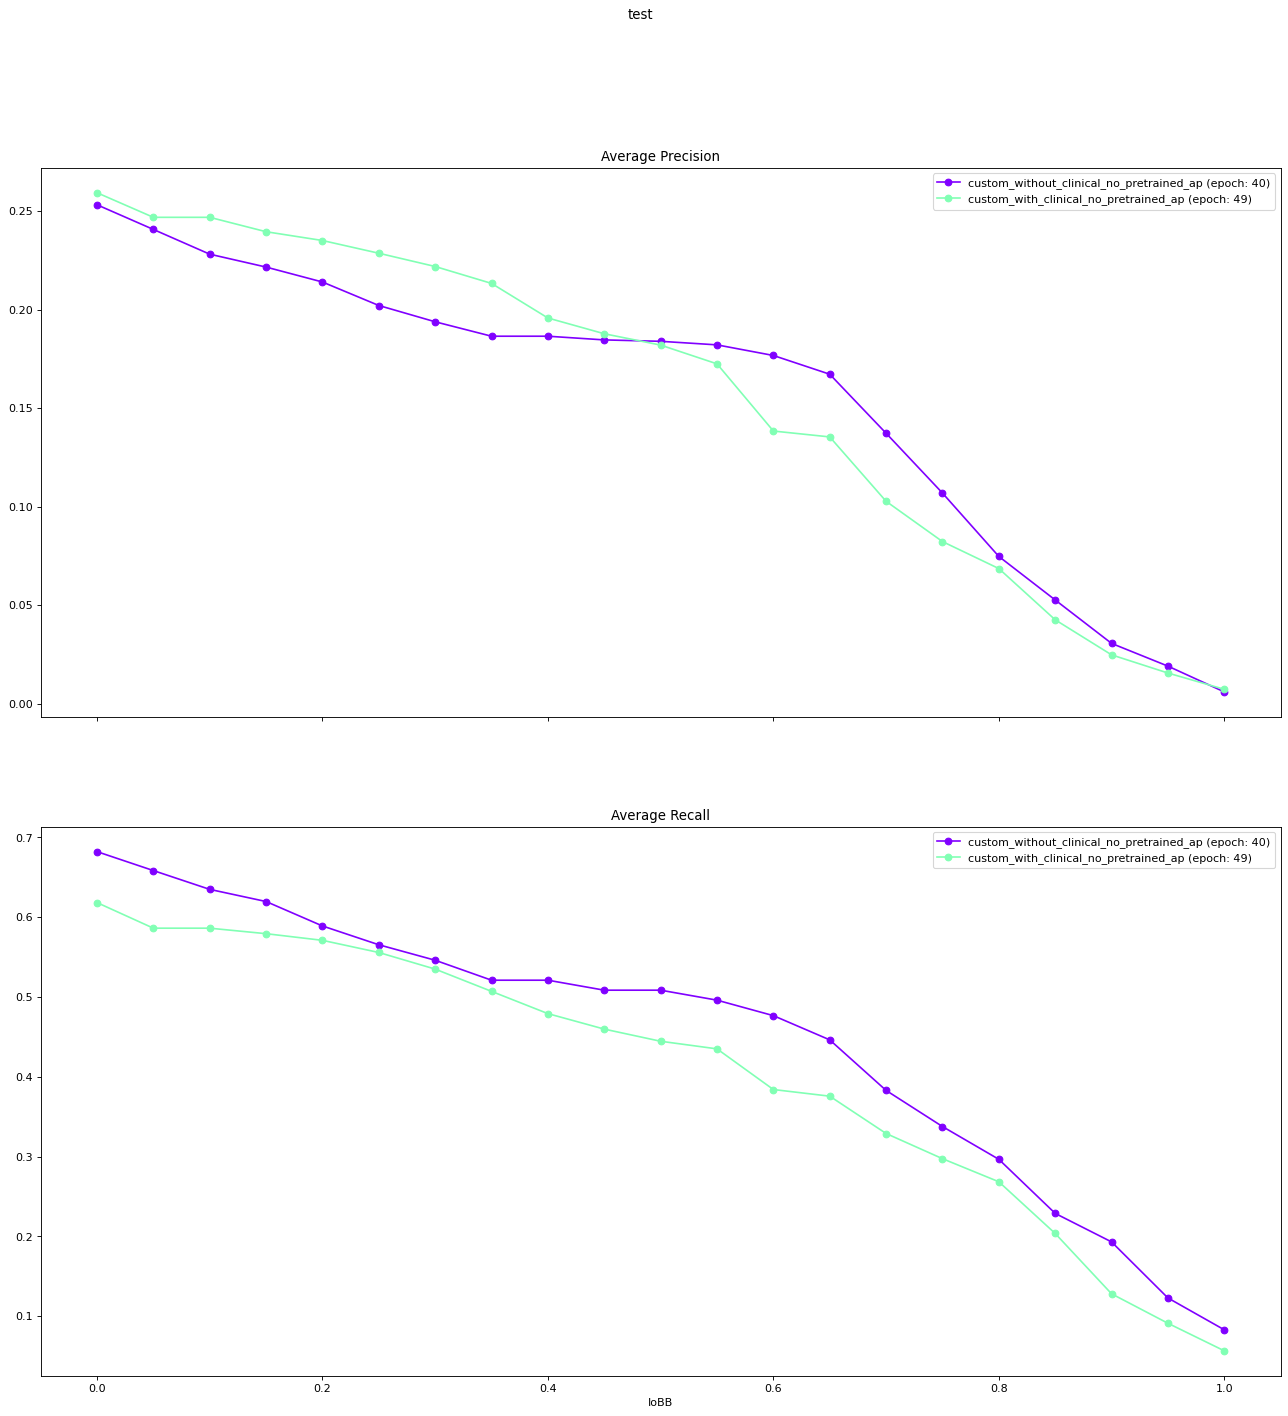

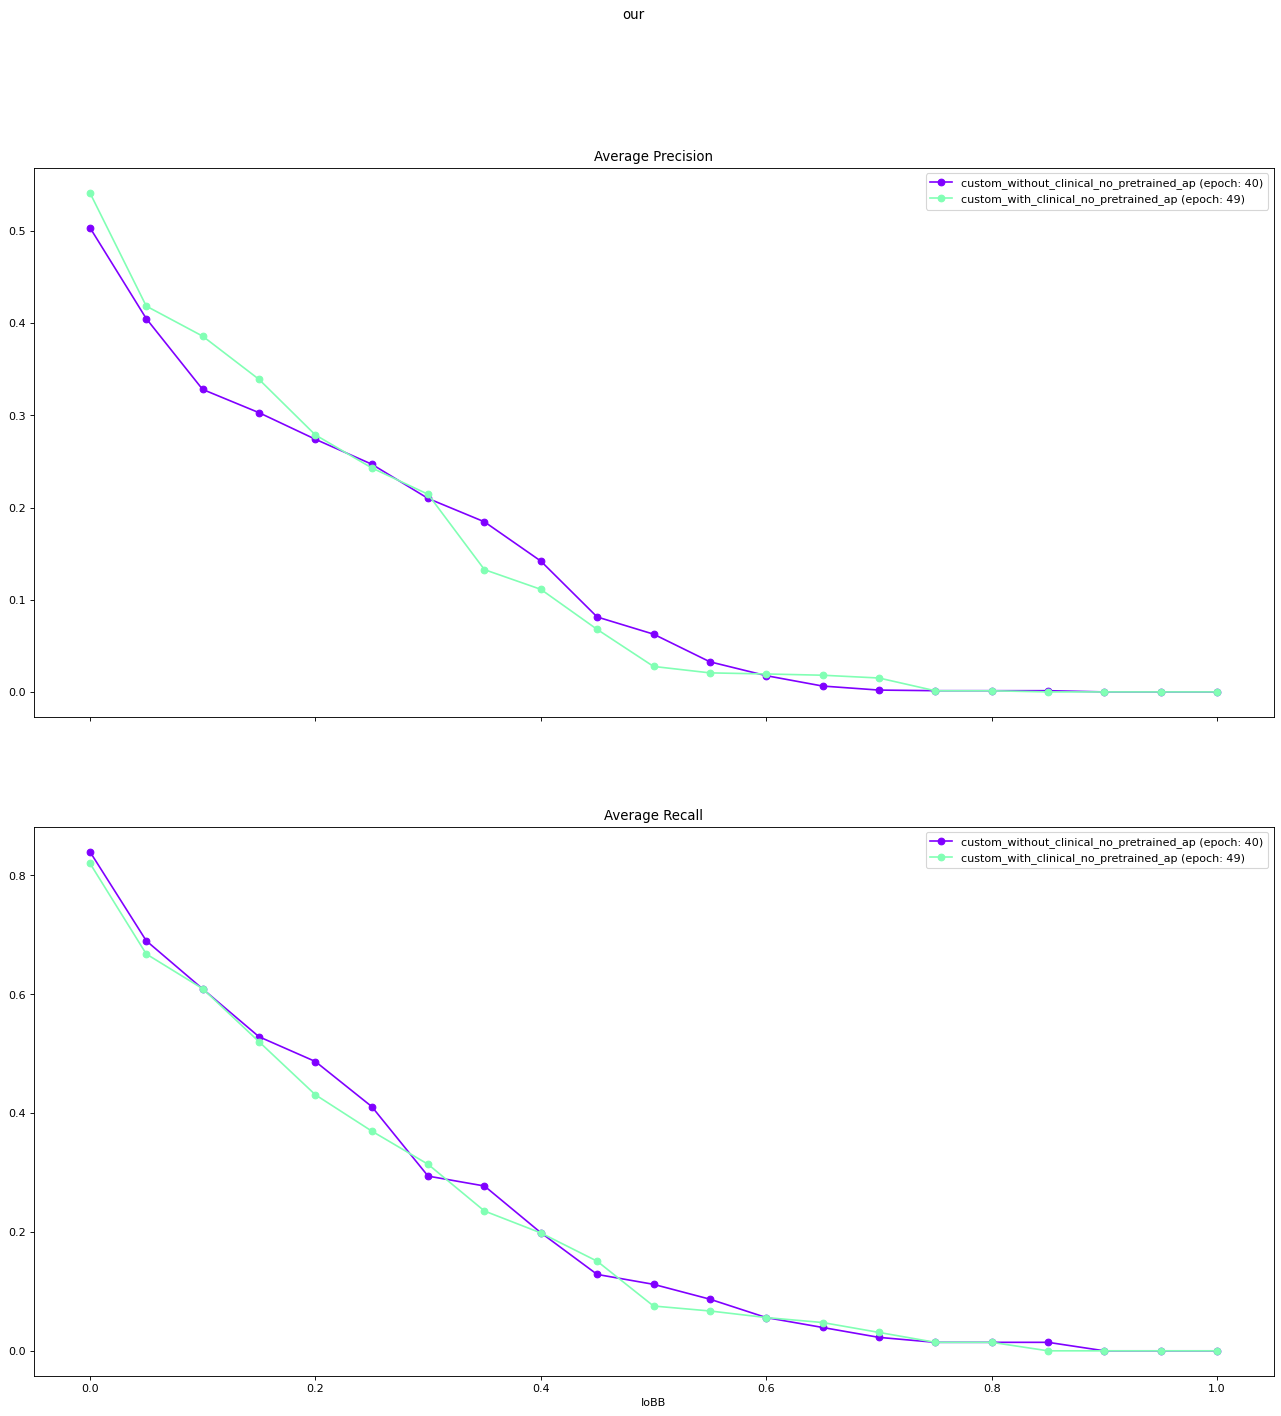

In [ ]:

clinical_varialbe_in_pretrained = [
    # TrainedModels.custom_without_clinical_no_pretrained_ar,
    TrainedModels.custom_without_clinical_no_pretrained_ap,
    # TrainedModels.custom_without_clinical_no_pretrained_final,

    # TrainedModels.custom_with_clinical_no_pretrained_ar,
    TrainedModels.custom_with_clinical_no_pretrained_ap,
    # TrainedModels.custom_with_clinical_no_pretrained_final,
]

_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "train", figsize=(20, 20)
)
_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "val", figsize=(20, 20)
)
_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "test", figsize=(20, 20)
)
_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "our", figsize=(20, 20)
)


In [ ]:
select_model = TrainedModels.custom_without_clinical_no_pretrained_final

with open(os.path.join("training_records", f"{select_model.value}.pkl"), "rb") as f:
    train_info: TrainingInfo = pickle.load(f)


NameError: name 'TrainingInfo' is not defined

In [ ]:
from utils.plot import plot_evaluator
from utils.save import TrainingInfo

# TrainedModels.custom_without_clinical_no_pretrained_ap,
# TrainedModels.custom_without_clinical_no_pretrained_ar,
# TrainedModels.custom_without_clinical_no_pretrained_final,


# TrainedModels.custom_without_clinical_pretrained_ap,
# TrainedModels.custom_without_clinical_pretrained_ar,
# TrainedModels.custom_without_clinical_pretrained_final,


# TrainedModels.custom_without_clinical_pretrained_ap,
# TrainedModels.custom_without_clinical_pretrained_ar,
# TrainedModels.custom_without_clinical_pretrained_final,

for select_model in [
    TrainedModels.custom_with_clinical_no_pretrained_final,
    TrainedModels.custom_without_clinical_no_pretrained_final,

]:
    with open(os.path.join("training_records", f"{select_model.value}.pkl"), "rb") as f:
        train_info: TrainingInfo = pickle.load(f)

    print(get_model_name(select_model))
    plot_evaluator(train_info.val_evaluators)


AttributeError: Can't get attribute 'ModelSetup' on <module 'models.load' from 'c:\\Users\\mike8\\Desktop\\multimodal-abnormalities-detection\\models\\load.py'>

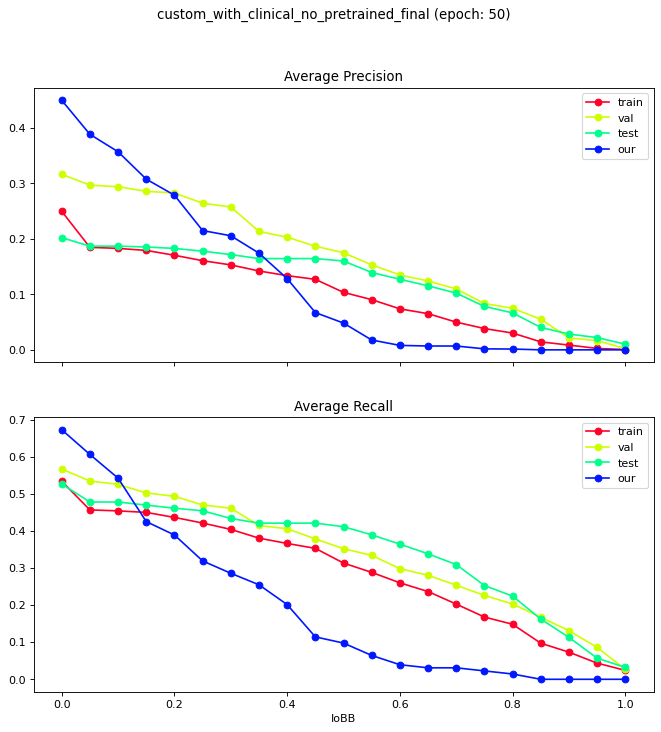

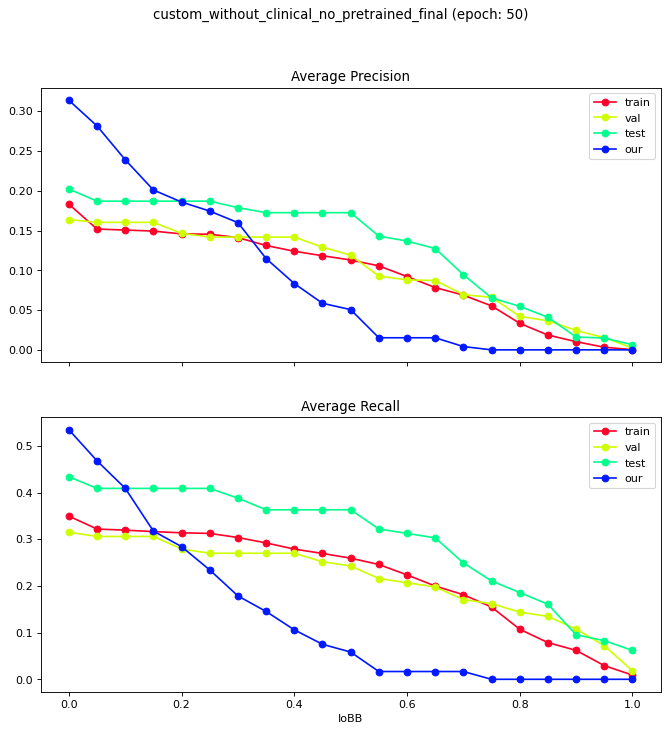

In [ ]:
for select_model in [
    TrainedModels.custom_with_clinical_no_pretrained_final,
    TrainedModels.custom_without_clinical_no_pretrained_final,

]:
    _= showModelOnDatasets(
        select_model=select_model,
        datasets=['train','val', 'test', 'our'],
        disease='all',
    )